# Neresbot 0.1

Modelos:
* Convolução
* Long Short-Term Memory
* SARIMA

In [1]:
import pandas as pd
import requests
import json
from pprint import pprint
import yahooquery as yq
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from tqdm import tqdm

In [2]:
# Função de padronização

def padronização(lista):
    máximo = max(lista)
    mínimo = min(lista)
    return list(map(lambda x: (x-mínimo)/(máximo-mínimo) if (máximo-mínimo) != 0 else 0.5,lista))

### Padronização:

Esta função força o menor valor ser igual a 0 e o maior ser igual a 1.  
Se min=3 e max=6:  
* Um valor 3 provocaria: (3-3)/(6-3)=0/3=0
* Um valor 6 provocaria: (6-3)(6-3)=3/3=1
* Um valor 4.5 provocaria: (4.5-3)/(6-3)=1.5/3=0.5
* Caso o maior e o menor valor sejam o mesmo, significa que todos os valores do vetor são iguais, então serão substituídos por 0.5

# Parâmetros Principais

In [135]:
# Baixar base de dados novamente (True) ou usar a preexistente (False)
download = False
# Usar menos dados e menos processamento
Parâmetros_reduzidos = False
# Criar o índice dos dataframes com base na coluna de datas (não recomendável)
indexing = False

Verif_Date = True

In [136]:
# Parâmetros Principais ##

# Tamanho das séries

Per_List = {0:'1d', 1:'5d', 2:'7d', 3:'60d', 4:'1mo', 5:'3mo', 6:'6mo', 7:'1y', 8:'2y', 9:'5y', 10:'10y', 11:'ytd', 12:'max'}
Interv_List = {0:'1m', 1:'2m', 2:'5m', 3:'15m', 4:'30m', 5:'60m', 6:'90m', 7:'1h', 8:'1d', 9:'5d', 10:'1wk', 11:'1mo', 12:'3mo'}

período = 9
período = Per_List[período]
print('período:',período)

período_res = 6
período_res = Per_List[período_res]
print('período_res:',período_res)

# Tamanho de cada período
intervalo = 8
intervalo = Interv_List[intervalo]
print('intervalo:',intervalo)

# Variação identificada nos períodos seguintes
Variação = 0.1
# Períodos em que o aumento pode ocorrer
Prospecção = 7
# Rótulos negativos, para redução de preço na mesma proporção de aumento
Bidirecional = True
# Rótulos categóricos tentam prever em quantos dias a variação ocorre, do contrário, o resultado será 0 (queda), 1 (manuntenção) ou 2 (aumento).
Categórico = False
# Rótulos positivos sobrepoem rótulos negativos
Otimista = True

# Número deperíodos que compõem um array.
defasagem = 20

# Separação entre teste e validação.
# Não mantenha a soma de ambos maior que 0.5
Teste_porcento = 0.3
Valid_porcento = 0.2

# Número máximo de épocas de treinamento
épocas = 25
# Número de épocas que, consecutivamente iguais em termos de acurácia, encerram o treino
paciência = 70
# Se a acurácia desejada é alcançada, o treino é encerrado
Acurácia_desejada = 0.9

período: 5y
período_res: 6mo
intervalo: 1d


In [137]:
# Metaparâmetros reduzidos


if Parâmetros_reduzidos:
    
    # Períodos em que o aumento pode ocorrer
    Prospecção = 5

    # Número deperíodos que compõem um array.
    defasagem = 7

    # Número máximo de épocas de treinamento
    épocas = 10
    # Número de épocas que, consecutivamente iguais em termos de acurácia, encerram o treino
    paciência = 5
    # Se a acurácia desejada é alcançada, o treino é encerrado
    Acurácia_desejada = 0.8

# Download dos Dados

## Testes

In [138]:
try:
    query = yq.Ticker('PETR4.SA', backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)
except:
    None
else:
    PETR4 = query.history(period='6mo', interval='1d',adj_timezone=True)
    PETR4 = PETR4.reset_index()
    print(PETR4.columns)
    PETR4['date'] = pd.to_datetime(PETR4['date'])
    PETR4['date'] = PETR4['date'].dt.tz_localize(None)
    PETR4['date'] = PETR4['date'].dt.date
    PETR4 = PETR4.sort_values('date', ascending=True)

try:
    query = yq.Ticker('PETR3.SA', backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)
except:
    None
else:
    PETR3 = query.history(period='3mo', interval='1d',adj_timezone=True)
    PETR3 = PETR3.reset_index()
    PETR3['date'] = pd.to_datetime(PETR4['date'])
    PETR3['date'] = PETR3['date'].dt.tz_localize(None)
    PETR3['date'] = PETR3['date'].dt.date
    PETR3 = PETR3.sort_values('date', ascending=True)


try:
    query = yq.Ticker('ELET5.SA', backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)
except:
    None
else:
    ELET5 = query.history(period='3mo', interval='1d',adj_timezone=True)
    ELET5 = ELET5.reset_index()
    ELET5['date'] = pd.to_datetime(PETR4['date'])
    ELET5['date'] = ELET5['date'].dt.tz_localize(None)
    ELET5['date'] = ELET5['date'].dt.date
    ELET5 = ELET5.sort_values('date', ascending=True)

Sim_Set = {'PETR4':PETR4,'ELET5':ELET5}

Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'adjclose',
       'dividends'],
      dtype='object')


In [139]:
query = yq.Ticker('AALR3.SA', backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)

df_teste = query.history(period='3mo', interval='1d',adj_timezone=True)

df_teste = df_teste.reset_index()

df_teste['date'] = pd.to_datetime(df_teste['date']).dt.date

df_teste

,symbol,date,open,high,low,close,volume,adjclose
0,AALR3.SA,2023-03-28,22.590000,22.680000,22.490000,22.680000,119200.0,22.680000
1,AALR3.SA,2023-03-29,22.650000,22.700001,22.510000,22.559999,117100.0,22.559999
2,AALR3.SA,2023-03-30,22.559999,22.600000,22.500000,22.530001,132200.0,22.530001
3,AALR3.SA,2023-04-02,22.500000,22.570000,22.420000,22.520000,142700.0,22.520000
4,AALR3.SA,2023-04-03,22.510000,22.650000,22.490000,22.540001,137600.0,22.540001
...,...,...,...,...,...,...,...,...
57,AALR3.SA,2023-06-21,23.240000,23.600000,23.240000,23.600000,1068200.0,23.600000
58,AALR3.SA,2023-06-22,23.620001,23.750000,23.490000,23.510000,550300.0,23.510000
59,AALR3.SA,2023-06-25,23.610001,23.610001,23.340000,23.510000,176900.0,23.510000
60,AALR3.SA,2023-06-26,23.610001,23.610001,23.360001,23.500000,159400.0,23.500000


In [140]:
df_teste.to_csv('df teste.csv', index=False)

**Fim dos testes.**

Os símbolos dos tickers são obtidos manualmente do site: https://www.dadosdemercado.com.br/bolsa/acoes

In [141]:
tickers = pd.read_csv("acoes-listadas.csv")

https://yahooquery.dpguthrie.com/

É criado um dicionário que conterá, como chave, o símbolo do ticker e, como valor, o dataframe relacionando medidas e períodos (dias).

Em cada dataframe é adicionado o devido dia da semana, numericamente.

In [142]:
# Os símbolos das empresas brasileiras recebem o sufixo ".SA".

símbolos = tickers['Código'] + '.SA'

In [143]:
# Verificando símbolos inválidos.

print(yq.Ticker(símbolos,
                backoff_factor=1, 
                progress=True, 
                status_forcelist=[404, 429, 500, 502, 503, 504], 
                asynchronous=True
                ).invalid_symbols)

None


Ajuste dos dados:
* Download e armazenamento:
  * Os índices são resetados
  * É verificado se os dados possuem a coluna 'date':
    * É criada a coluna equivalente aos dias semanais
    * Armazenamento no dict dados1
    * Os dados são salvos na pasta 'dados'

In [144]:
from yq_downloader import downloader

In [145]:
#if download:
    #downloader(tickers = símbolos, período = período, report = True, dir = 'dados')
    #downloader(tickers = símbolos, período = período_res, report = True, dir = 'dados_res')

In [146]:
# Função de Download

def hist_download(símbolos,período,intervalo,dir):
    dados1 = {}
    falhas = []
    sem_datas = []
    datas_repetidas = []

    all_dates = []

    for tckr in tqdm(símbolos):
        query = yq.Ticker(tckr, backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)
        try:
            histórico = query.history(period=período, interval=intervalo,adj_timezone=True)
        except:
            falhas.append(tckr)
            #print(ticker,"falhou.")
        else:
            histórico = histórico.reset_index()
            if 'date' in histórico.columns: # Ajusta os tempos e salva em dados1
                histórico['date'] = pd.to_datetime(histórico['date'])
                histórico['weekday'] = histórico['date'].dt.weekday # Cria dias da semana
                histórico['weekday'] = padronização(histórico['weekday'])
                histórico['yearday'] = histórico['date'].dt.dayofyear # Cria dias da semana
                histórico['yearday'] = padronização(histórico['yearday'])
                histórico['date'] = histórico['date'].dt.tz_localize(None) # Remove timezone
                histórico['date'] = histórico['date'].dt.date # Remove horário
                histórico = histórico.sort_values('date', ascending=True) # Organiza por data
                if histórico['date'].duplicated().any():
                    datas_repetidas.append(tckr)
                
                dados1[tckr] = histórico # Salva tudo em dados1

            else:
                #print(ticker,"não contém datas, mas contém:")
                #print(histórico.columns)
                sem_datas.append(tckr)

    print(len(dados1),"tickers salvos com sucesso.")
    print(len(falhas),"tickers apresentaram falha.")
    print(len(sem_datas),"tickers não contém datas.")
    print(len(datas_repetidas),"tickers contém datas repetidas.")

    # Separa as colunas
    Medidas = []
    print('Medidas:')
    for tckr in dados1:
        for col in dados1[tckr].columns:
            if col not in Medidas:
                Medidas.append(col)
                print(f' {col}')

    # Adiciona colunas às tabelas que não as tinha
    for tckr in dados1.keys():
        for col in Medidas:
            if col not in dados1[tckr].columns:
                dados1[tckr][col] = 0

    # Tornando todos os datasets iguais em termos de datas
    all_dates = set()
    for tckr in dados1.keys():
        all_dates.update(set(dados1[tckr]['date']))
    print(len(all_dates),"datas de negociação encontradas.")

    for tckr in dados1.keys():
        missing_dates = all_dates - set(dados1[tckr]['date'])
        missing_data = pd.DataFrame({'date': list(missing_dates)})
        dados1[tckr] = pd.concat([dados1[tckr], missing_data], ignore_index=True)
        # Classifica o dataframe pela coluna 'date' para garantir a ordem correta
        dados1[tckr] = dados1[tckr].sort_values('date').reset_index(drop=True)
        # Preenche cada valor nulo com o número válido anterior
        dados1[tckr] = dados1[tckr].fillna(method = 'ffill')

    # Cria a pasta se ela não existe
    if not os.path.exists(dir):
        os.makedirs(dir)
        
    # Arquiva cada uma das tabelas em .csv
    for tckr, df in dados1.items():
        caminho_arquivo = os.path.join(dir, f'{tckr}.csv')
        df.to_csv(caminho_arquivo, index=False)

    return (falhas, sem_datas, datas_repetidas, Medidas, all_dates)

In [147]:
if download:
    hist_download(símbolos,
                  período,
                  intervalo,
                  'dados')

In [148]:
if download:
    a,b,c,d,c = hist_download(símbolos,período_res,intervalo,'dados_reduzidos')

# Preparação dos Dados

In [149]:
# Carregando dados .csv

dados1 = {}  # Dicionário vazio para armazenar as tabelas
Shapes = []
Rows = []
Columns = []

if Parâmetros_reduzidos:
    print('Dados reduzidos.')
    pasta = 'dados_reduzidos'
else:
    print('Dados completos.')
    pasta = 'dados'

# Percorre todos os arquivos na pasta
for nome_arquivo in os.listdir(pasta):
    if nome_arquivo.endswith('.csv'):  # Verifica se o arquivo é um arquivo CSV
        caminho_arquivo = os.path.join(pasta, nome_arquivo)  # Caminho completo para o arquivo

        histórico = pd.read_csv(caminho_arquivo)
        if 'date' in histórico.columns: # Ajusta os tempos e salva em dadosRe
            histórico['date'] = pd.to_datetime(histórico['date'])
            histórico['date'] = histórico['date'].dt.tz_localize(None) # Remove timezone
            histórico['date'] = histórico['date'].dt.date # Remove horário
            histórico = histórico.sort_values('date') # Organiza por data
        
        dados1[os.path.splitext(nome_arquivo)[0]] = histórico
        Shapes.append(histórico.shape)
        Rows.append(len(histórico.index))
        Columns.append(len(histórico.columns))

# Imprime o dicionário com as tabelas
print(f'{len(dados1)} históricos salvos.')

Rows = pd.Series(Rows).value_counts()
Columns = pd.Series(Columns).value_counts()


Dados completos.


525 históricos salvos.


In [150]:
Rows

1541    466
1239     59
dtype: int64

In [151]:
Columns

12    466
11     59
dtype: int64

In [152]:
# Separando as tabelas por grupos de semelhantes
 # Por datas
 # Por formato

sets_by_date = []

for tckr in dados1.keys():
    hist = dados1[tckr]

    if len(sets_by_date) == 0:
        sets_by_date.append({})
    
    set_index = 0
    Verif = True

    # Todo ticker começa olhando para primeiro set

    while Verif:
        # Se o set para o qual está olhando (set_index) está vazio, cria um 'date' para o set e coloca o ticker atual no set.
        if len(sets_by_date[set_index]) == 0:
            sets_by_date[set_index][tckr] = hist
            sets_by_date[set_index]['hist'] = hist['date']
            sets_by_date[set_index]['shape'] = hist.shape
            Verif = False                                              # Próximo ticker, set 0
        else:
            if (sets_by_date[set_index]['hist'].equals(hist['date'])) and (sets_by_date[set_index]['shape'] == hist.shape):
                sets_by_date[set_index][tckr] = hist
                Verif = False                                          # Próximo ticker, set 0
            else:
                set_index += 1                                         # Próximo set, set 0
                if set_index == len(sets_by_date):
                    sets_by_date.append({})

print(f'{type(sets_by_date)}, Número de sets: {len(sets_by_date)}')
print(f'{type(sets_by_date[0])},{len(sets_by_date[0])}')
print(type(sets_by_date[0]['PETR4.SA']),len(sets_by_date[0]['PETR4.SA']))


<class 'list'>, Número de sets: 2
<class 'dict'>,468
<class 'pandas.core.frame.DataFrame'> 1541


In [153]:
for Set in sets_by_date:
    print(Set['shape'],len(Set))

(1541, 12) 468
(1239, 11) 61


Maiores empresas na bolsa:
* Petrobras: PETR4.SA, PETR3.SA
* Vale: VALE.SA
* Itaú Unibanco: ITUB4.SA, ITUB3.SA, ITSA4.SA
* Ambev: ABEV.SA, 
* Bradesco: BBDC3.SA,  BBDC4.SA
* Weg: WEGE3.SA
* Santander: SANB3.SA, SANB4.SA
* Eletrobrás: ELET5.SA, ELET6.SA, ELET5.SA
* BTG: BPAC3.SA, BPAC5.SA
* Banco do Brasil: BBAS3.SA

In [154]:
princ_tckrs = ['PETR4.SA',
               'PETR3.SA',
               'VALE.SA',
               'ITUB4.SA',
               'ITUB3.SA',
               'ITSA4.SA',
               'ABEV.SA',
               'BBDC3.SA',
               'BBDC4.SA',
               'WEGE3.SA',
               'SANB3.SA',
               'SANB4.SA',
               'ELET5.SA',
               'ELET6.SA',
               'ELET5.SA',
               'BPAC3.SA',
               'BPAC5.SA',
               'BBAS3.SA']


for tckr in princ_tckrs:
    for i in range(len(sets_by_date)):
        if tckr in sets_by_date[i].keys():
            Shape = sets_by_date[i]['shape']
            print(f'{tckr} - set id: {i}; tamanho do set: {len(sets_by_date[i])}, shape: {Shape}')
            #print(' ',list(sets_by_date[i][tckr].columns))

PETR4.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
PETR3.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
ITUB4.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
ITUB3.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
ITSA4.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
BBDC3.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
BBDC4.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
WEGE3.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
SANB3.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
SANB4.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
ELET5.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
ELET6.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
ELET5.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
BPAC3.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
BPAC5.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)
BBAS3.SA - set id: 0; tamanho do set: 468, shape: (1541, 12)


In [155]:
# Verificação dos formatos das tabelas.

for sets in sets_by_date:
    Len = {}
    for tckr in sets.keys():
        if tckr not in ('hist','shape'):
            Shape = str(sets[tckr].shape)
            if Shape not in Len.keys():
                Len[Shape] = 0
            Len[Shape] += 1
    print(Len)

{'(1541, 12)': 466}
{'(1239, 11)': 59}


Se os ticker existentes em determinados dados não puderemser baixados para o período necessário para a prospecção, não devem ser incluídos no modelo.

In [156]:
dados2 = sets_by_date[0]
if 'hist' in dados2.keys():
    del dados2['hist']
if 'shape' in dados2.keys():
    del dados2['shape']


In [157]:
# Verificando se todas as colunas 'date' são iguais 

if Verif_Date:
    ticker_divergentes = pd.DataFrame(columns=dados2.keys(), index=dados2.keys())

    for column in dados2.keys():
        for index in dados2.keys():
            if dados1[column]['date'].equals(dados2[index]['date']):
                ticker_divergentes.at[index,column] = True
            else:
                ticker_divergentes.at[index,column] = False

    ticker_divergentes.to_csv('ticker_divergentes.csv')
    ticker_divergentes

# Convolução

## Rótulos

Cada linha analisa se há aumento expressivo nos próximos 5 períodos.

Se não houver, o rótulo será 0; Caso contrário, será o número de dias em que o aumento ocorre.  
Há uma variável ajustável para determinar o nível do aumento.

In [158]:
print('Parâmetros_reduzidos:',Parâmetros_reduzidos)
print('Prospecção:',Prospecção)
print('Bidirecional:',Bidirecional)
print('Categórico:',Categórico)

Parâmetros_reduzidos: False
Prospecção: 7
Bidirecional: True
Categórico: False


In [159]:
if Otimista:
    # 2 - Valores dos Rótulos, separando as buscaspositivas e negativas
    Verbose = False
    print(f'') if Verbose else None

    print('SE BIDIRECIONAL: OS VALORES MAIS ALTOS SERÃO O DOBRO DA PROSPECÇÃO.')
    # Coluna para os rótulos

    for i,j in dados2.items():
        j['rótulos'] = 0
        j['compar'] = 0

    # Valores para os rótulos

    for tckr, df in tqdm(dados2.items()):                  # Para cada ticker, tabela:                      # reseta o índice da tabela
        print() if Verbose else None
        print('Ticker:',tckr) if Verbose else None
        
        for i, row in df.iterrows():
            price_now = row['close']
            price_contester_high = row['close']
            price_contester_high_id = i
            price_contester_low = row['close']
            price_contester_low_id = i
            print(' i:',i,'; price_now e contests:',price_now) if Verbose else None


            # Iteração entre os próximos "Prospecção" itens, procurando negativos.
            if Bidirecional:
                print(' Procurando aumentos:') if Verbose else None
                for j in range(i+1, i+1+Prospecção):
                    
                    # Se J ainda é dentro da tabela
                    if j < len(df):
                        print(f'  j:{j}') if Verbose else None
                        j_low = df.loc[j, 'low']
                        print(f'   low de j={j}: {j_low}.') if Verbose else None

                        # se o preço avaliado é menor ou igual à redução esperada e é bidirecional:
                        if (j_low <= (1-Variação)*price_now) and (j_low < price_contester_low) and Bidirecional:
                            print(f'     post_low ({j_low}) supera a variação esperada ({(1 + Variação)*price_now}) e o último maior ({price_contester_low}).') if Verbose else None
                            if Categórico:
                                dados2[tckr].loc[i, 'rótulos'] = i - j
                            else:
                                dados2[tckr].loc[i, 'rótulos'] = -1
                            dados2[tckr].loc[i, 'compar'] = j_low
                            price_contester_low = j_low
                            price_contester_low_id = j
                            temp = dados2[tckr].loc[i, 'rótulos']
                            print(f'     Rótulo atualizado: {temp}') if Verbose else None
                            print(f'     O último menor preço para o id {i} agora é {price_contester_low}, do id {j}.') if Verbose else None
                        else:
                            temp = dados2[tckr].loc[i, 'rótulos']
                            print(f'     Rótulo permanece: {temp}') if Verbose else None
                    else:
                        print('   j ultrapassa o limite da tabela') if Verbose else None
                    
                    

            # Procurando positivos.
            print(' Procurando aumentos:') if Verbose else None
            for j in range(i+1, i+1+Prospecção):
                
                # Se J ainda é dentro da tabela
                if j < len(df):
                    print(f'  j:{j}') if Verbose else None
                    j_high = df.loc[j, 'high']
                    print(f'   high de j={j}: {j_high}.') if Verbose else None
                    
                    # se o preço avaliado é maior ou igual ao aumento esperado:
                    if (j_high >= (1 + Variação)*price_now) and (j_high > price_contester_high):
                        print(f'     j_high ({j_high}) supera a variação esperada ({(1 + Variação)*price_now}) e o último maior ({price_contester_high}).') if Verbose else None
                        if Categórico:
                            dados2[tckr].loc[i, 'rótulos'] = j - i
                        else:
                            dados2[tckr].loc[i, 'rótulos'] = 1
                        dados2[tckr].loc[i, 'compar'] = j_high
                        price_contester_high = j_high
                        price_contester_high_id = j
                        temp = dados2[tckr].loc[i, 'rótulos']
                        print(f'     Rótulo atualizado: {temp}') if Verbose else None
                        print(f'     O último maior preço para o id {i} agora é {price_contester_high}, do id {j}.') if Verbose else None
                    else:
                        temp = dados2[tckr].loc[i, 'rótulos']
                        print(f'     Rótulo permanece: {temp}') if Verbose else None
                else:
                    print('   j ultrapassa o limite da tabela') if Verbose else None


            
            if dados2[tckr].loc[i, 'rótulos'] == 0:
                print(f'  Nenhum id entre {i+1} e {j} apresentou valores consideráveis') if Verbose else None
                print(f'    j_high depois: {j_high}') if Verbose else None
                print(f'    j_low depois: {j_low}') if Verbose else None


            # Remoção de rótulos negativos
            if Bidirecional:
                if Categórico:
                    dados2[tckr].loc[i, 'rótulos'] += Prospecção
                else:
                    dados2[tckr].loc[i, 'rótulos'] += 1
            temp = dados2[tckr].loc[i, 'rótulos']
            print(f'    Para o id ({i}) o rótulo definitivo é {temp}') if Verbose else None

            if Verbose:
                if (((dados2[tckr].loc[i, 'rótulos'] != Prospecção) and (Categórico)) or (dados2[tckr].loc[i, 'rótulos'] != 1)) and (tckr == 'ITSA4.SA'):
                    print(row['symbol'], dados2[tckr].loc[i, 'rótulos'], (((j_high/price_now)-1)*100), (((j_high/price_now)-1)*100)) if Verbose else None
                    print(row['symbol'], dados2[tckr].loc[i, 'rótulos'], (((j_low/price_now)-1)*100), (((j_low/price_now)-1)*100)) if Verbose else None
        
        # print(df.head()) #??

SE BIDIRECIONAL: OS VALORES MAIS ALTOS SERÃO O DOBRO DA PROSPECÇÃO.


  0%|          | 0/466 [00:00<?, ?it/s]

100%|██████████| 466/466 [07:27<00:00,  1.04it/s]


In [160]:
if not Otimista:
    # 2 - Valores dos Rótulos, separando as buscaspositivas e negativas
    Verbose = False
    print(f'') if Verbose else None

    print('SE BIDIRECIONAL: OS VALORES MAIS ALTOS SERÃO O DOBRO DA PROSPECÇÃO.')
    # Coluna para os rótulos

    for i,j in dados2.items():
        j['rótulos'] = 0
        j['compar'] = 0

    # Valores para os rótulos

    for tckr, df in tqdm(dados2.items()):                  # Para cada ticker, tabela:                      # reseta o índice da tabela
        print() if Verbose else None
        print('Ticker:',tckr) if Verbose else None
        
        for i, row in df.iterrows():
            price_now = row['close']
            price_contester_high = row['close']
            price_contester_high_id = i
            price_contester_low = row['close']
            price_contester_low_id = i
            print(' i:',i,'; price_now e contests:',price_now) if Verbose else None


            # Procurando positivos.
            print(' Procurando aumentos:') if Verbose else None
            for j in range(i+1, i+1+Prospecção):
                
                # Se J ainda é dentro da tabela
                if j < len(df):
                    print(f'  j:{j}') if Verbose else None
                    j_high = df.loc[j, 'high']
                    print(f'   high de j={j}: {j_high}.') if Verbose else None
                    
                    # se o preço avaliado é maior ou igual ao aumento esperado:
                    if (j_high >= (1 + Variação)*price_now) and (j_high > price_contester_high):
                        print(f'     j_high ({j_high}) supera a variação esperada ({(1 + Variação)*price_now}) e o último maior ({price_contester_high}).') if Verbose else None
                        if Categórico:
                            dados2[tckr].loc[i, 'rótulos'] = j - i
                        else:
                            dados2[tckr].loc[i, 'rótulos'] = 1
                        dados2[tckr].loc[i, 'compar'] = j_high
                        price_contester_high = j_high
                        price_contester_high_id = j
                        temp = dados2[tckr].loc[i, 'rótulos']
                        print(f'     Rótulo atualizado: {temp}') if Verbose else None
                        print(f'     O último maior preço para o id {i} agora é {price_contester_high}, do id {j}.') if Verbose else None
                    else:
                        temp = dados2[tckr].loc[i, 'rótulos']
                        print(f'     Rótulo permanece: {temp}') if Verbose else None
                else:
                    print('   j ultrapassa o limite da tabela') if Verbose else None


            
            # Iteração entre os próximos "Prospecção" itens, procurando negativos.
            if Bidirecional:
                print(' Procurando aumentos:') if Verbose else None
                for j in range(i+1, i+1+Prospecção):
                    
                    # Se J ainda é dentro da tabela
                    if j < len(df):
                        print(f'  j:{j}') if Verbose else None
                        j_low = df.loc[j, 'low']
                        print(f'   low de j={j}: {j_low}.') if Verbose else None

                        # se o preço avaliado é menor ou igual à redução esperada e é bidirecional:
                        if (j_low <= (1-Variação)*price_now) and (j_low < price_contester_low) and Bidirecional:
                            print(f'     post_low ({j_low}) supera a variação esperada ({(1 + Variação)*price_now}) e o último maior ({price_contester_low}).') if Verbose else None
                            if Categórico:
                                dados2[tckr].loc[i, 'rótulos'] = i - j
                            else:
                                dados2[tckr].loc[i, 'rótulos'] = -1
                            dados2[tckr].loc[i, 'compar'] = j_low
                            price_contester_low = j_low
                            price_contester_low_id = j
                            temp = dados2[tckr].loc[i, 'rótulos']
                            print(f'     Rótulo atualizado: {temp}') if Verbose else None
                            print(f'     O último menor preço para o id {i} agora é {price_contester_low}, do id {j}.') if Verbose else None
                        else:
                            temp = dados2[tckr].loc[i, 'rótulos']
                            print(f'     Rótulo permanece: {temp}') if Verbose else None
                    else:
                        print('   j ultrapassa o limite da tabela') if Verbose else None
                    
                    

            if dados2[tckr].loc[i, 'rótulos'] == 0:
                print(f'  Nenhum id entre {i+1} e {j} apresentou valores consideráveis') if Verbose else None
                print(f'    j_high depois: {j_high}') if Verbose else None
                print(f'    j_low depois: {j_low}') if Verbose else None


            # Remoção de rótulos negativos
            if Bidirecional:
                if Categórico:
                    dados2[tckr].loc[i, 'rótulos'] += Prospecção
                else:
                    dados2[tckr].loc[i, 'rótulos'] += 1
            temp = dados2[tckr].loc[i, 'rótulos']
            print(f'    Para o id ({i}) o rótulo definitivo é {temp}') if Verbose else None

            if Verbose:
                if (((dados2[tckr].loc[i, 'rótulos'] != Prospecção) and (Categórico)) or (dados2[tckr].loc[i, 'rótulos'] != 1)) and (tckr == 'ITSA4.SA'):
                    print(row['symbol'], dados2[tckr].loc[i, 'rótulos'], (((j_high/price_now)-1)*100), (((j_high/price_now)-1)*100)) if Verbose else None
                    print(row['symbol'], dados2[tckr].loc[i, 'rótulos'], (((j_low/price_now)-1)*100), (((j_low/price_now)-1)*100)) if Verbose else None
        
        # print(df.head()) #??

In [161]:
print('  Rótulos')
for tckr in dados2:
    print(tckr+':', dados2[tckr]['rótulos'].min(), dados2[tckr]['rótulos'].max())

  Rótulos
AALR3.SA: 0 2
ABCB4.SA: 0 2
ABEV3.SA: 0 2
AERI3.SA: 0 2
AESB3.SA: 0 2
AFLT3.SA: 0 2
AGRO3.SA: 0 2
AGXY3.SA: 0 2
AHEB3.SA: 0 2
AHEB5.SA: 0 2
AHEB6.SA: 0 2
ALLD3.SA: 0 2
ALPA3.SA: 0 2
ALPA4.SA: 0 2
ALPK3.SA: 0 2
ALSO3.SA: 0 2
ALUP3.SA: 0 2
ALUP4.SA: 0 2
AMAR3.SA: 0 2
AMBP3.SA: 0 2
AMER3.SA: 0 2
ANIM3.SA: 0 2
APER3.SA: 0 2
ARML3.SA: 0 2
ARZZ3.SA: 0 2
ASAI3.SA: 0 2
ATMP3.SA: 0 2
ATOM3.SA: 0 2
AVLL3.SA: 0 2
AZEV3.SA: 0 2
AZEV4.SA: 0 2
AZUL4.SA: 0 2
B3SA3.SA: 0 2
BAHI3.SA: 0 2
BALM3.SA: 0 2
BALM4.SA: 0 2
BAUH4.SA: 0 2
BAZA3.SA: 0 2
BBAS3.SA: 0 2
BBDC3.SA: 0 2
BBDC4.SA: 0 2
BBSE3.SA: 0 2
BDLL3.SA: 0 2
BDLL4.SA: 0 2
BEEF3.SA: 0 2
BEES3.SA: 0 2
BEES4.SA: 0 2
BGIP3.SA: 0 2
BGIP4.SA: 0 2
BIOM3.SA: 0 2
BLAU3.SA: 0 2
BMEB3.SA: 0 2
BMEB4.SA: 0 2
BMGB4.SA: 0 2
BMIN3.SA: 0 2
BMIN4.SA: 0 2
BMKS3.SA: 0 2
BMOB3.SA: 0 2
BNBR3.SA: 0 2
BOAS3.SA: 0 2
BOBR4.SA: 0 2
BPAC3.SA: 0 2
BPAC5.SA: 0 2
BPAN4.SA: 0 2
BRAP3.SA: 0 2
BRAP4.SA: 0 2
BRFS3.SA: 0 2
BRGE11.SA: 0 2
BRGE12.SA: 0 2
BRGE3.SA: 0 2
BRGE5.SA

In [162]:
for tckr in dados2:
    print(dados2[tckr].tail(4))

        symbol        date       open       high        low  close    volume  \
1537  AALR3.SA  2023-06-25  23.610001  23.610001  23.340000  23.51  176900.0   
1538  AALR3.SA  2023-06-26  23.610001  23.610001  23.360001  23.50  159400.0   
1539  AALR3.SA  2023-06-27  23.610001  23.610001  23.360001  23.50  159400.0   
1540  AALR3.SA  2023-06-29  23.680000  23.719999  23.580000  23.65  179000.0   

      adjclose  dividends  weekday   yearday  splits  rótulos  compar  
1537     23.51        0.0      1.0  0.482094     0.0        1     0.0  
1538     23.50        0.0      0.0  0.484848     0.0        1     0.0  
1539     23.50        0.0      0.0  0.484848     0.0        1     0.0  
1540     23.65        0.0      0.5  0.493113     0.0        1     0.0  
        symbol        date       open       high        low      close  \
1537  ABCB4.SA  2023-06-25  18.510000  18.530001  18.040001  18.370001   
1538  ABCB4.SA  2023-06-26  18.799999  19.000000  18.360001  18.620001   
1539  ABCB4.SA  2

In [163]:
print('  Dividendos')
for tckr in dados2:
    print(tckr+':',dados2[tckr]['dividends'].max())

  Dividendos
AALR3.SA: 0.087297
ABCB4.SA: 0.554453
ABEV3.SA: 0.7623
AERI3.SA: 0.020702
AESB3.SA: 0.165705
AFLT3.SA: 0.29471
AGRO3.SA: 3.238673
AGXY3.SA: 0.167864
AHEB3.SA: 0.0
AHEB5.SA: 0.0
AHEB6.SA: 0.0
ALLD3.SA: 0.570983
ALPA3.SA: 0.247202
ALPA4.SA: 0.271712
ALPK3.SA: 0.0
ALSO3.SA: 0.519014
ALUP3.SA: 0.48
ALUP4.SA: 0.48
AMAR3.SA: 0.0
AMBP3.SA: 0.303171
AMER3.SA: 0.620963
ANIM3.SA: 0.0023
APER3.SA: 0.323684
ARML3.SA: 0.118727
ARZZ3.SA: 0.831022
ASAI3.SA: 0.125038
ATMP3.SA: 0.0
ATOM3.SA: 0.320385
AVLL3.SA: 0.0
AZEV3.SA: 0.0
AZEV4.SA: 0.0
AZUL4.SA: 0.0
B3SA3.SA: 0.265538
BAHI3.SA: 0.0
BALM3.SA: 0.34
BALM4.SA: 0.41
BAUH4.SA: 1.20933
BAZA3.SA: 6.809764
BBAS3.SA: 0.826881
BBDC3.SA: 0.712738
BBDC4.SA: 0.784011
BBSE3.SA: 1.910841
BDLL3.SA: 0.0
BDLL4.SA: 0.0
BEEF3.SA: 0.729812
BEES3.SA: 0.181503
BEES4.SA: 0.181503
BGIP3.SA: 2.243082
BGIP4.SA: 2.46739
BIOM3.SA: 0.0
BLAU3.SA: 0.205591
BMEB3.SA: 0.623826
BMEB4.SA: 0.686208
BMGB4.SA: 0.31551
BMIN3.SA: 1.420175
BMIN4.SA: 1.589625
BMKS3.SA: 57.7863

## Transformação das matrizes: Separando os dias como objetos numpy.

Classes que contenham as matrizes, os rótulos e a identificação do dia.

In [164]:
# Todos os dataframes:

df_concatenado = pd.concat(dados2.values(), axis=1)

In [165]:
df_concatenado.to_csv('df_concatenado.csv',index=True)

O último dia não deve estar incluso no treinamento por não possuir rótulo.

Dimensões:
* Medidas:
  * open
  * high
  * low
  * close
  * volume
  * adjclose
  * weekday
  * yearday
  * dividends
  * splits
* tickers
* Dias (atual e anteriores)

In [166]:
# Adição de colunas "necessárias"
# Remoção das colunas "desnecessárias"

Colunas_Necessárias = ['open',
                    'high',
                    'low', 
                    'close', 
                    'volume', 
                    'adjclose', 
                    'weekday', 
                    'yearday', 
                    'dividends', 
                    'splits', 
                    'rótulos']

dados3 = {}

for tckr in dados2.keys():
    for c in Colunas_Necessárias:
        if c not in dados2[tckr].columns:
            dados2[tckr][c] = 0

for tckr in dados2.keys():
    dados3[tckr] = dados2[tckr][Colunas_Necessárias]

In [167]:
dados3['AALR3.SA'].columns

Index(['open', 'high', 'low', 'close', 'volume', 'adjclose', 'weekday',
       'yearday', 'dividends', 'splits', 'rótulos'],
      dtype='object')

In [168]:
# Tendo certeza de que todas as tabelas têm o mesmo tamanho.

for t in dados3.keys():
    for k in dados3.keys():
        Série = len(dados3[t])
        dif = len(dados3[t])-len(dados3[k])
        if dif != 0:
            print(t,'-',k,'=',dif)

In [169]:
Série

1541

Há uma variável ajustável para determinar quantos dias serão olhados para trás.

In [170]:
# Criação lista completa

Tensor = []

Rótulos = {}
for tckr in dados3.keys():
    Rótulos[tckr] = []

for i in range(Série-Prospecção):
    lvl1 = []
    for tckr in dados3.keys():
        lvl2 = []
        for coluna in dados3[tckr].columns:
            if coluna != 'rótulos':
                lvl3 = []
                for j in range(i - defasagem, i):
                    if j >= 0:
                        k = j
                    else:
                        k = 0
                    lvl3.append(dados3[tckr].at[k,coluna])
                    if coluna not in ['weekday','yearday']:
                        lvl3p = padronização(lvl3)
            lvl2.append(lvl3p)
        lvl1.append(lvl2)
        Rótulos[tckr].append(dados3[tckr].at[i,'rótulos'])
    Tensor.append(lvl1)

## Separação entre Treino, Teste e Validação.

É preciso garantir que as matrizes sejam embaralhadas, mas que os rótulos permaneçam atrelados adequadamente.

In [171]:
type(Tensor)

list

In [172]:
Treino_tensor = []
Teste_tensor = []
Valid_tensor = []

Treino_rótulo = {}
for tckr in dados3.keys():
    Treino_rótulo[tckr] = []

Teste_rótulo = {}
for tckr in dados3.keys():
    Teste_rótulo[tckr] = []

Valid_rótulo = {}
for tckr in dados3.keys():
    Valid_rótulo[tckr] = []

id_teste_valid = random.sample(list(range(len(Tensor))), int(round(len(Tensor)*(Teste_porcento+Valid_porcento), 0)))

id_valid = random.sample(id_teste_valid, int(round(len(Tensor)*Valid_porcento, 0)))

for i in range(len(Tensor)):
    if i in id_valid:
        Valid_tensor.append(Tensor[i])
        for tckr in Valid_rótulo.keys():
            Valid_rótulo[tckr].append(Rótulos[tckr][i])
            
    elif i in id_teste_valid:
        Teste_tensor.append(Tensor[i])
        for tckr in Teste_rótulo.keys():
            Teste_rótulo[tckr].append(Rótulos[tckr][i])

    else:
        Treino_tensor.append(Tensor[i])
        for tckr in Treino_rótulo.keys():
            Treino_rótulo[tckr].append(Rótulos[tckr][i])

Treino_tensor = np.array(Treino_tensor)
Teste_tensor = np.array(Teste_tensor)
Valid_tensor = np.array(Valid_tensor)

for tckr in Treino_rótulo.keys():
    Treino_rótulo[tckr] = np.array(Treino_rótulo[tckr])
for tckr in Teste_rótulo.keys():
    Teste_rótulo[tckr] = np.array(Teste_rótulo[tckr])
for tckr in Valid_rótulo.keys():
    Valid_rótulo[tckr] = np.array(Valid_rótulo[tckr])

In [173]:
print(Treino_tensor.shape)
print(Teste_tensor.shape)
print(Valid_tensor.shape)

print()

print(len(Treino_rótulo),len(Treino_rótulo['PETR4.SA']))
print(len(Teste_rótulo),len(Teste_rótulo['PETR4.SA']))
print(len(Valid_rótulo),len(Valid_rótulo['PETR4.SA']))

(767, 466, 11, 20)
(460, 466, 11, 20)
(307, 466, 11, 20)

466 767
466 460
466 307


## Modelo

* Para cada ticker (a partir do dicionário de rótulos):  
    * O modelo é treinado seguindo aquele ticker como rótulo (com uma função)  
    * O modelo é validado  
    * Se o modelo é válido:  
        * A previsão é tentada:  
        * Se o resultado é diferente de zero E a probabilidade é alta:  
                * O deploy é salvo

Exemplo com um ticker: PTR4.SA

In [174]:
Shape = Treino_tensor.shape[1:]
Ativação = 'relu'

print(Shape)

(466, 11, 20)


In [175]:
# Cria o objeto de sequência de camadas
modelo = models.Sequential()

modelo.add(layers.Conv2D(64, (4, 2), activation = 'relu', input_shape = Shape))
modelo.add(layers.MaxPooling2D((2, 2)))

modelo.add(layers.Conv2D(64, (4, 2), activation = 'relu'))
modelo.add(layers.MaxPooling2D((2, 2)))

modelo.add(layers.Conv2D(64, (1, 1), activation = 'relu'))
modelo.add(layers.MaxPooling2D((2, 2)))

modelo.add(layers.Flatten())

modelo.add(layers.Dense(64, activation = 'relu'))

modelo.add(layers.Dense(32, activation = 'relu'))

modelo.add(layers.Dense((Prospecção+1), activation = 'softmax'))

modelo.summary()

Model: "sequential_474"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1422 (Conv2D)        (None, 463, 10, 64)       10304     
                                                                 
 max_pooling2d_1422 (MaxPool  (None, 231, 5, 64)       0         
 ing2D)                                                          
                                                                 
 conv2d_1423 (Conv2D)        (None, 228, 4, 64)        32832     
                                                                 
 max_pooling2d_1423 (MaxPool  (None, 114, 2, 64)       0         
 ing2D)                                                          
                                                                 
 conv2d_1424 (Conv2D)        (None, 114, 2, 64)        4160      
                                                                 
 max_pooling2d_1424 (MaxPool  (None, 57, 1, 64)     

In [176]:
modelo.compile(optimizer = 'adam', 
                   loss = 'sparse_categorical_crossentropy', 
                   metrics = ['accuracy'])

In [177]:
class AccuracyThresholdCallback(Callback):
    def __init__(self, accuracy_threshold):
        super(AccuracyThresholdCallback, self).__init__()
        self.accuracy_threshold = accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= self.accuracy_threshold:
            self.model.stop_training = True
            print(f"\nAtingiu a acurácia desejada ({self.accuracy_threshold}). Treinamento interrompido.")

In [178]:
# Criando um parâmetro de parada com o objeto EarlyStopping
early_stopping = EarlyStopping(monitor='accuracy', mode='max', patience=paciência, verbose=1)

# Salvando a melhor época.
checkpoint = ModelCheckpoint('Modelos\\melhor_CNN.h5', monitor='val_accuracy', mode='max', save_best_only=True)

# Criar o objeto do callback personalizado
accuracy_callback = AccuracyThresholdCallback(Acurácia_desejada)

In [179]:
# Treinamento e teste

history = modelo.fit(Treino_tensor, 
                         Treino_rótulo['PETR4.SA'], 
                         epochs = 5, 
                         validation_data = (Teste_tensor, Teste_rótulo['PETR4.SA']),
                         callbacks=[early_stopping, checkpoint])

Epoch 1/5


24/24 [==============================] - 10s 346ms/step - loss: 1.8274 - accuracy: 0.7653 - val_loss: 1.0577 - val_accuracy: 0.8304
Epoch 2/5
24/24 [==============================] - 4s 156ms/step - loss: 0.8428 - accuracy: 0.7940 - val_loss: 0.6296 - val_accuracy: 0.8304
Epoch 3/5
24/24 [==============================] - 4s 153ms/step - loss: 0.6942 - accuracy: 0.7940 - val_loss: 0.5876 - val_accuracy: 0.8304
Epoch 4/5
24/24 [==============================] - 4s 175ms/step - loss: 0.6608 - accuracy: 0.7940 - val_loss: 0.5763 - val_accuracy: 0.8304
Epoch 5/5
24/24 [==============================] - 3s 143ms/step - loss: 0.6594 - accuracy: 0.7940 - val_loss: 0.5807 - val_accuracy: 0.8304


In [180]:
modelo.evaluate(Valid_tensor, Valid_rótulo['PETR4.SA'], verbose = 2)

10/10 - 1s - loss: 0.7100 - accuracy: 0.7687 - 568ms/epoch - 57ms/step


[0.7099760174751282, 0.7687296271324158]

10/10 - 0s - loss: 0.7100 - accuracy: 0.7687 - 439ms/epoch - 44ms/step


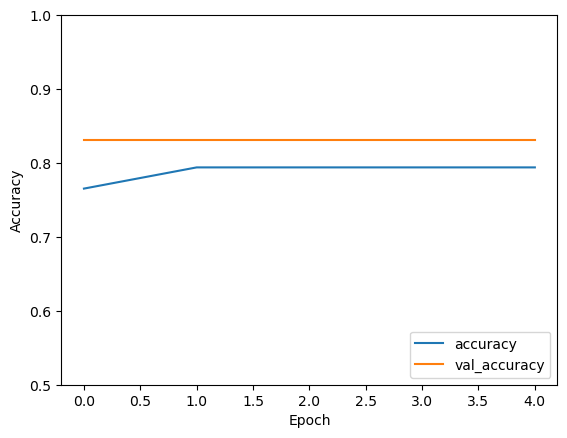

In [181]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelo.evaluate(Valid_tensor, Valid_rótulo['PETR4.SA'], verbose=2)

10/10 [==============================] - 0s 26ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2 2 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 2 2 2 2 1 1
 2 1 2 2 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 2 2 1
 2 1 2 1 1 1 2 0 1 1 1

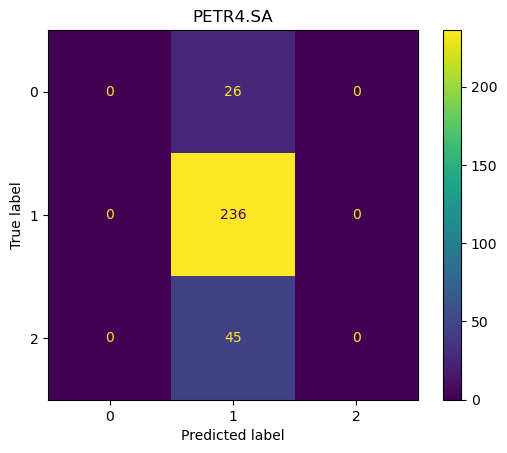

In [182]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_predictions = modelo.predict(Valid_tensor)

test_predicted_labels = np.argmax(test_predictions, axis=1)
print(test_predicted_labels)

test_true_labels = np.array(Valid_rótulo['PETR4.SA'])
print(test_true_labels)

cm = confusion_matrix(test_true_labels, test_predicted_labels)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.title('PETR4.SA')
plt.show()

  0%|          | 0/466 [00:00<?, ?it/s]

10/10 [==============================] - 1s 47ms/step


  0%|          | 1/466 [01:18<10:08:26, 78.51s/it]

10/10 [==============================] - 1s 57ms/step


  0%|          | 2/466 [02:41<10:26:03, 80.96s/it]

10/10 [==============================] - 1s 39ms/step


  1%|          | 3/466 [04:17<11:17:19, 87.77s/it]

10/10 [==============================] - 1s 49ms/step


  1%|          | 4/466 [05:43<11:10:41, 87.10s/it]

10/10 [==============================] - 0s 18ms/step


  1%|          | 5/466 [07:13<11:18:16, 88.28s/it]

10/10 [==============================] - 1s 40ms/step


  1%|▏         | 6/466 [08:47<11:31:39, 90.22s/it]

10/10 [==============================] - 1s 19ms/step


  2%|▏         | 7/466 [10:16<11:27:20, 89.85s/it]

10/10 [==============================] - 1s 33ms/step


  2%|▏         | 8/466 [11:46<11:25:55, 89.86s/it]

10/10 [==============================] - 1s 17ms/step


  2%|▏         | 9/466 [13:13<11:18:23, 89.07s/it]

10/10 [==============================] - 1s 62ms/step


  2%|▏         | 10/466 [15:18<12:39:45, 99.97s/it]

10/10 [==============================] - 1s 45ms/step


  2%|▏         | 11/466 [16:46<12:10:43, 96.36s/it]

10/10 [==============================] - 1s 38ms/step


  3%|▎         | 12/466 [18:11<11:43:11, 92.93s/it]

10/10 [==============================] - 1s 51ms/step


  3%|▎         | 13/466 [19:47<11:47:51, 93.76s/it]

10/10 [==============================] - 1s 50ms/step


  3%|▎         | 14/466 [21:13<11:30:16, 91.63s/it]

10/10 [==============================] - 1s 56ms/step


  3%|▎         | 15/466 [22:42<11:21:45, 90.70s/it]

10/10 [==============================] - 1s 32ms/step


  3%|▎         | 16/466 [24:08<11:10:57, 89.46s/it]

10/10 [==============================] - 1s 30ms/step


  4%|▎         | 17/466 [25:42<11:19:06, 90.75s/it]

10/10 [==============================] - 1s 32ms/step


  4%|▍         | 18/466 [27:13<11:17:38, 90.76s/it]

10/10 [==============================] - 1s 56ms/step


  4%|▍         | 19/466 [28:49<11:28:45, 92.45s/it]

10/10 [==============================] - 1s 36ms/step


  4%|▍         | 20/466 [30:20<11:22:35, 91.83s/it]

10/10 [==============================] - 1s 38ms/step


c:\Users\fnsb\anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
  5%|▍         | 21/466 [31:47<11:11:18, 90.51s/it]

10/10 [==============================] - 0s 21ms/step


  5%|▍         | 22/466 [33:15<11:04:47, 89.84s/it]

10/10 [==============================] - 1s 32ms/step


  5%|▍         | 23/466 [35:00<11:34:55, 94.12s/it]

10/10 [==============================] - 1s 31ms/step


  5%|▌         | 24/466 [36:28<11:21:01, 92.45s/it]

10/10 [==============================] - 0s 21ms/step


  5%|▌         | 25/466 [38:53<13:16:01, 108.30s/it]

10/10 [==============================] - 0s 25ms/step


  6%|▌         | 26/466 [40:17<12:19:38, 100.86s/it]

10/10 [==============================] - 0s 32ms/step


  6%|▌         | 27/466 [41:43<11:46:32, 96.57s/it] 

10/10 [==============================] - 1s 46ms/step


  6%|▌         | 28/466 [43:09<11:21:19, 93.33s/it]

10/10 [==============================] - 1s 49ms/step


  6%|▌         | 29/466 [44:34<11:01:41, 90.85s/it]

10/10 [==============================] - 1s 32ms/step


  6%|▋         | 30/466 [46:04<10:57:12, 90.44s/it]

10/10 [==============================] - 1s 58ms/step


  7%|▋         | 31/466 [47:32<10:50:10, 89.68s/it]

10/10 [==============================] - 1s 47ms/step


  7%|▋         | 32/466 [48:59<10:44:02, 89.04s/it]

10/10 [==============================] - 0s 23ms/step


  7%|▋         | 33/466 [50:28<10:41:07, 88.84s/it]

10/10 [==============================] - 0s 22ms/step


  7%|▋         | 34/466 [51:54<10:33:33, 87.99s/it]

10/10 [==============================] - 0s 37ms/step


  8%|▊         | 35/466 [53:20<10:29:00, 87.57s/it]

10/10 [==============================] - 1s 46ms/step


  8%|▊         | 36/466 [54:46<10:24:17, 87.11s/it]

10/10 [==============================] - 1s 41ms/step


  8%|▊         | 37/466 [56:13<10:21:22, 86.91s/it]

10/10 [==============================] - 1s 32ms/step


  8%|▊         | 38/466 [57:43<10:26:59, 87.90s/it]

10/10 [==============================] - 0s 28ms/step


  8%|▊         | 39/466 [59:12<10:29:12, 88.41s/it]

10/10 [==============================] - 1s 33ms/step


  9%|▊         | 40/466 [1:00:41<10:27:43, 88.41s/it]

10/10 [==============================] - 1s 37ms/step


  9%|▉         | 41/466 [1:02:08<10:22:59, 87.95s/it]

10/10 [==============================] - 1s 46ms/step


  9%|▉         | 42/466 [1:03:37<10:24:56, 88.43s/it]

10/10 [==============================] - 1s 53ms/step


  9%|▉         | 43/466 [1:05:06<10:23:03, 88.38s/it]

10/10 [==============================] - 0s 38ms/step


  9%|▉         | 44/466 [1:06:31<10:15:43, 87.54s/it]

10/10 [==============================] - 1s 45ms/step


 10%|▉         | 45/466 [1:07:59<10:15:41, 87.75s/it]

10/10 [==============================] - 0s 20ms/step


 10%|▉         | 46/466 [1:09:27<10:14:52, 87.84s/it]

10/10 [==============================] - 0s 20ms/step


 10%|█         | 47/466 [1:10:55<10:13:12, 87.81s/it]

10/10 [==============================] - 1s 48ms/step


 10%|█         | 48/466 [1:12:25<10:15:43, 88.38s/it]

10/10 [==============================] - 0s 36ms/step


 11%|█         | 49/466 [1:13:56<10:20:03, 89.22s/it]

10/10 [==============================] - 0s 28ms/step


 11%|█         | 50/466 [1:15:24<10:15:03, 88.71s/it]

10/10 [==============================] - 1s 41ms/step


 11%|█         | 51/466 [1:16:51<10:11:48, 88.45s/it]

10/10 [==============================] - 1s 62ms/step


 11%|█         | 52/466 [1:18:21<10:12:37, 88.79s/it]

10/10 [==============================] - 0s 33ms/step


 11%|█▏        | 53/466 [1:19:52<10:15:04, 89.36s/it]

10/10 [==============================] - 0s 22ms/step


 12%|█▏        | 54/466 [1:21:20<10:11:42, 89.08s/it]

10/10 [==============================] - 1s 52ms/step


 12%|█▏        | 55/466 [1:22:50<10:11:41, 89.30s/it]

10/10 [==============================] - 1s 53ms/step


 12%|█▏        | 56/466 [1:24:16<10:04:10, 88.42s/it]

10/10 [==============================] - 1s 43ms/step


 12%|█▏        | 57/466 [1:25:44<10:01:24, 88.23s/it]

10/10 [==============================] - 1s 48ms/step


 12%|█▏        | 58/466 [1:27:11<9:57:18, 87.84s/it] 

10/10 [==============================] - 0s 38ms/step


 13%|█▎        | 59/466 [1:28:41<10:00:33, 88.53s/it]

10/10 [==============================] - 1s 40ms/step


 13%|█▎        | 60/466 [1:30:12<10:03:50, 89.24s/it]

10/10 [==============================] - 1s 56ms/step


 13%|█▎        | 61/466 [1:31:41<10:02:33, 89.27s/it]

10/10 [==============================] - 1s 50ms/step


 13%|█▎        | 62/466 [1:33:08<9:55:00, 88.37s/it] 

10/10 [==============================] - 0s 33ms/step


 14%|█▎        | 63/466 [1:34:36<9:53:10, 88.31s/it]

10/10 [==============================] - 1s 45ms/step


 14%|█▎        | 64/466 [1:36:01<9:44:45, 87.28s/it]

10/10 [==============================] - 1s 45ms/step


 14%|█▍        | 65/466 [1:37:26<9:40:16, 86.83s/it]

10/10 [==============================] - 1s 45ms/step


 14%|█▍        | 66/466 [1:38:51<9:33:23, 86.01s/it]

10/10 [==============================] - 1s 42ms/step


 14%|█▍        | 67/466 [1:40:17<9:33:13, 86.20s/it]

10/10 [==============================] - 0s 23ms/step


 15%|█▍        | 68/466 [1:41:42<9:28:02, 85.63s/it]

10/10 [==============================] - 0s 31ms/step


 15%|█▍        | 69/466 [1:43:11<9:35:08, 86.92s/it]

10/10 [==============================] - 1s 42ms/step


 15%|█▌        | 70/466 [1:44:38<9:32:15, 86.71s/it]

10/10 [==============================] - 0s 42ms/step


 15%|█▌        | 71/466 [1:46:07<9:35:58, 87.49s/it]

10/10 [==============================] - 0s 26ms/step


 15%|█▌        | 72/466 [1:47:37<9:40:18, 88.37s/it]

10/10 [==============================] - 1s 51ms/step


 16%|█▌        | 73/466 [1:49:03<9:32:39, 87.43s/it]

10/10 [==============================] - 1s 56ms/step


 16%|█▌        | 74/466 [1:50:32<9:35:38, 88.11s/it]

10/10 [==============================] - 1s 50ms/step


 16%|█▌        | 75/466 [1:52:01<9:36:02, 88.40s/it]

10/10 [==============================] - 1s 45ms/step


 16%|█▋        | 76/466 [1:53:30<9:35:02, 88.47s/it]

10/10 [==============================] - 0s 24ms/step


 17%|█▋        | 77/466 [1:54:58<9:32:25, 88.29s/it]

10/10 [==============================] - 0s 33ms/step


 17%|█▋        | 78/466 [1:56:30<9:38:24, 89.44s/it]

10/10 [==============================] - 1s 55ms/step


 17%|█▋        | 79/466 [1:58:00<9:36:58, 89.45s/it]

10/10 [==============================] - 0s 24ms/step


 17%|█▋        | 80/466 [1:59:30<9:36:58, 89.69s/it]

10/10 [==============================] - 1s 57ms/step


 17%|█▋        | 81/466 [2:00:59<9:33:50, 89.43s/it]

10/10 [==============================] - 1s 52ms/step


 18%|█▊        | 82/466 [2:02:29<9:34:19, 89.74s/it]

10/10 [==============================] - 1s 38ms/step


 18%|█▊        | 83/466 [2:03:54<9:24:18, 88.40s/it]

10/10 [==============================] - 0s 22ms/step


 18%|█▊        | 84/466 [2:05:18<9:14:34, 87.10s/it]

10/10 [==============================] - 0s 25ms/step


 18%|█▊        | 85/466 [2:06:47<9:15:06, 87.42s/it]

10/10 [==============================] - 1s 56ms/step


 18%|█▊        | 86/466 [2:08:15<9:14:49, 87.60s/it]

10/10 [==============================] - 1s 30ms/step


 19%|█▊        | 87/466 [2:09:43<9:15:33, 87.95s/it]

10/10 [==============================] - 1s 44ms/step


 19%|█▉        | 88/466 [2:11:12<9:14:48, 88.07s/it]

10/10 [==============================] - 1s 53ms/step


 19%|█▉        | 89/466 [2:12:44<9:22:10, 89.47s/it]

10/10 [==============================] - 0s 26ms/step


 19%|█▉        | 90/466 [2:14:11<9:16:00, 88.72s/it]

10/10 [==============================] - 0s 20ms/step


 20%|█▉        | 91/466 [2:17:06<9:25:00, 90.40s/it]


MemoryError: Unable to allocate 120. MiB for an array with shape (307, 466, 11, 20) and data type float32

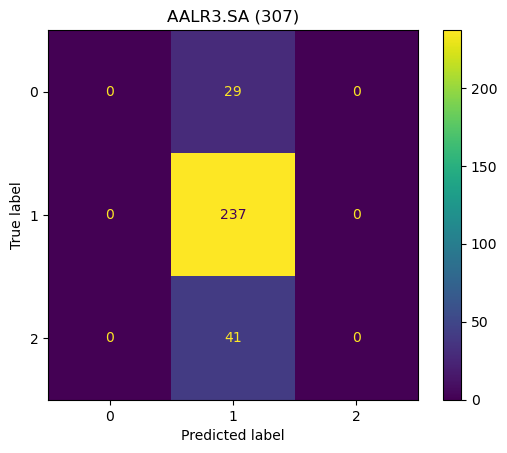

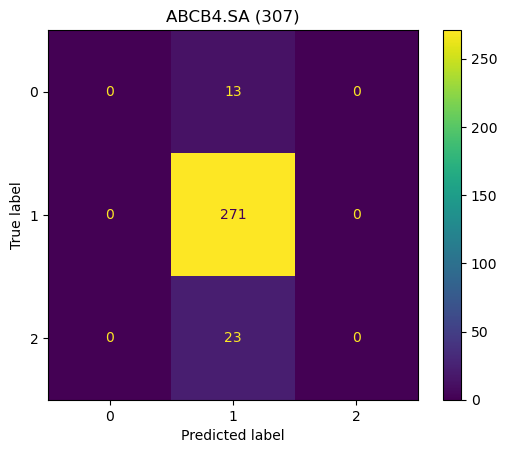

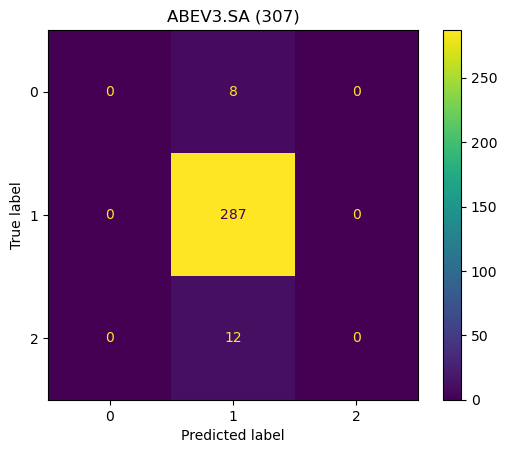

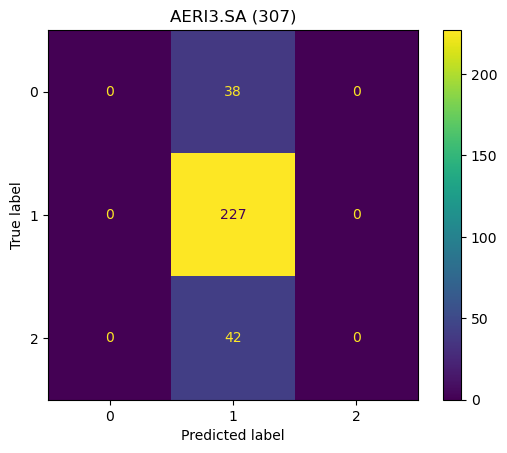

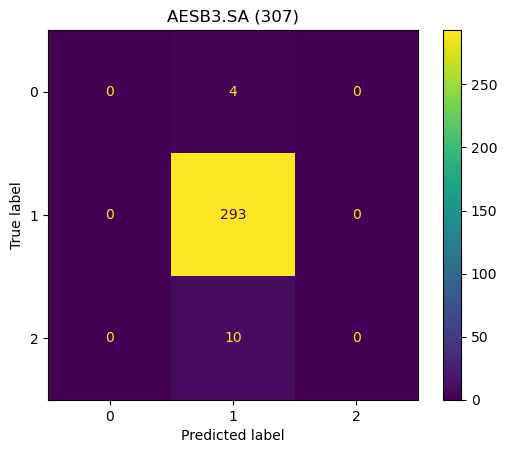

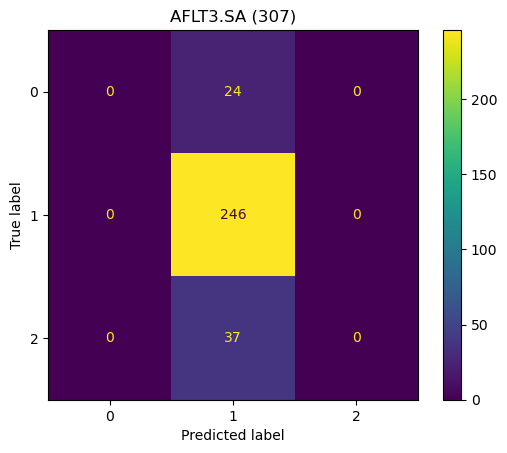

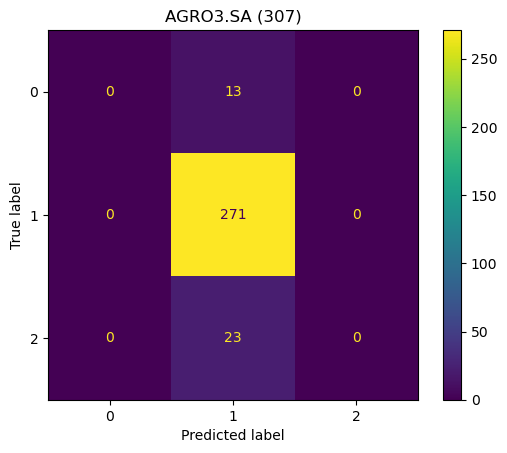

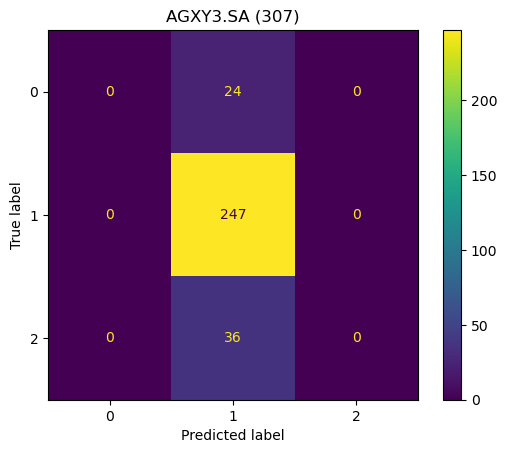

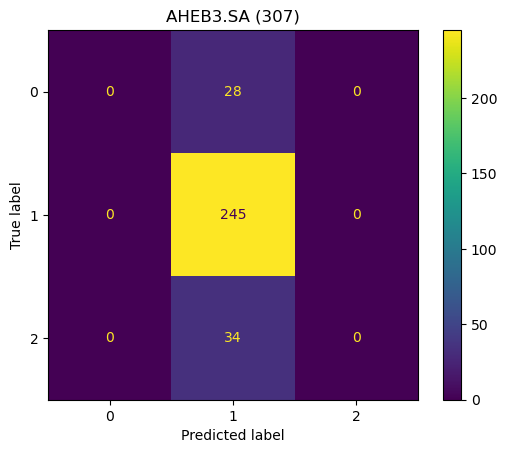

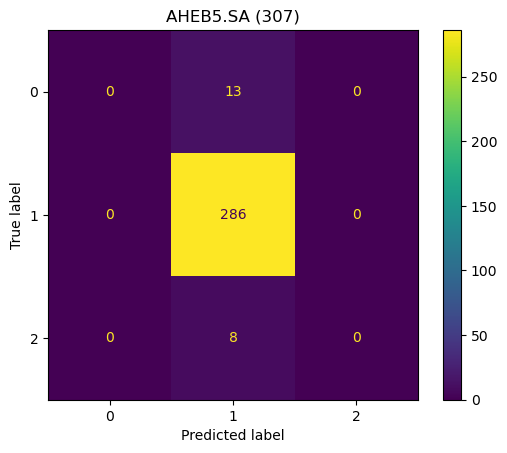

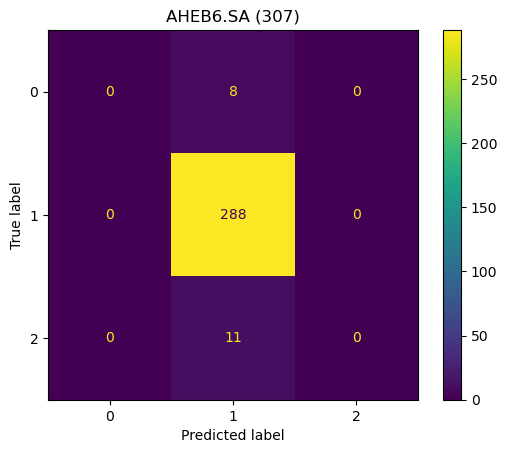

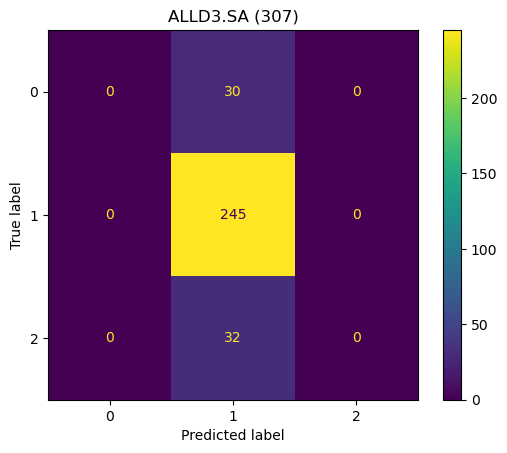

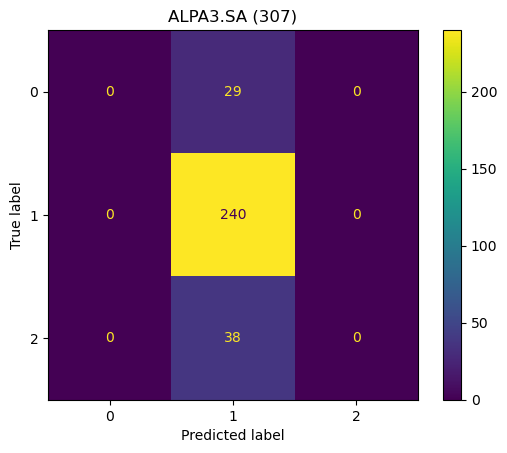

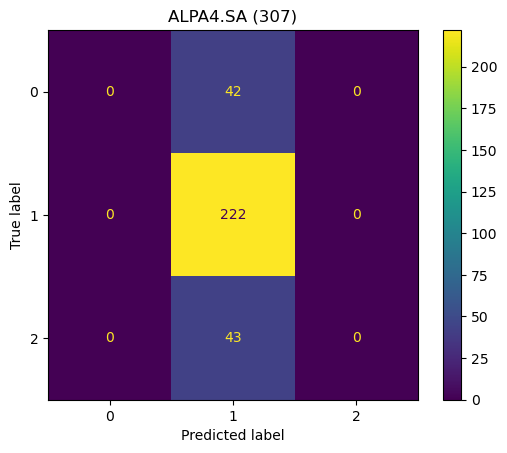

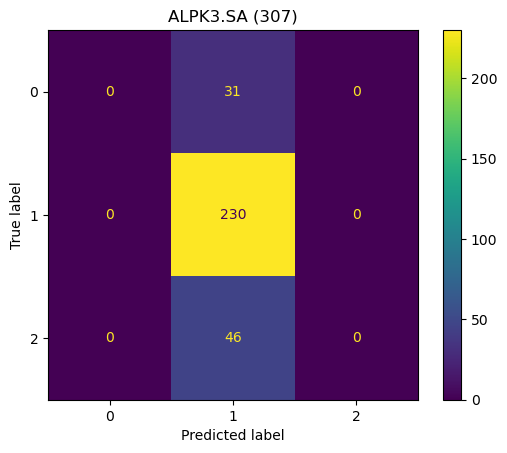

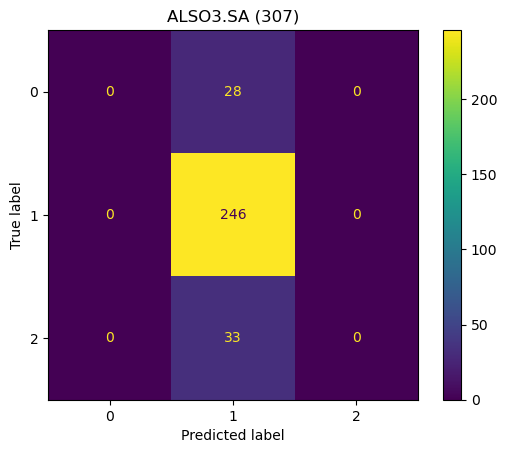

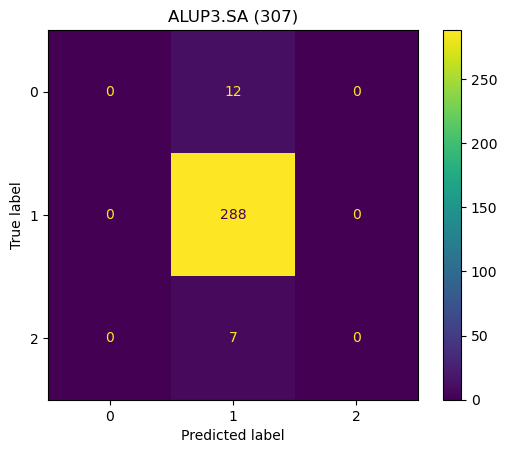

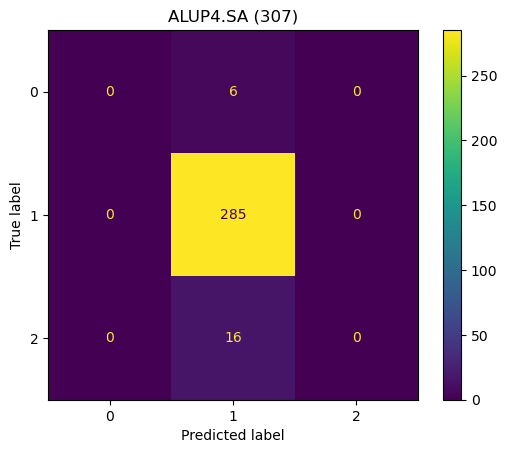

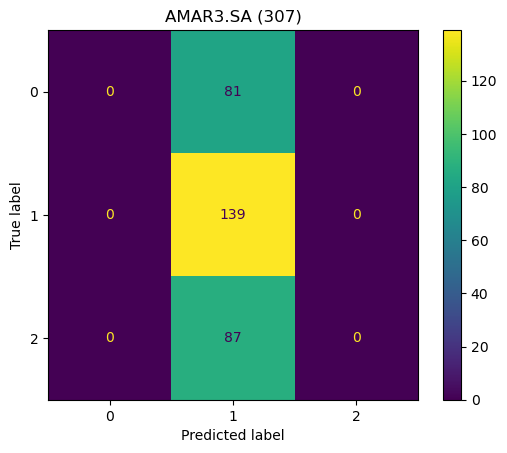

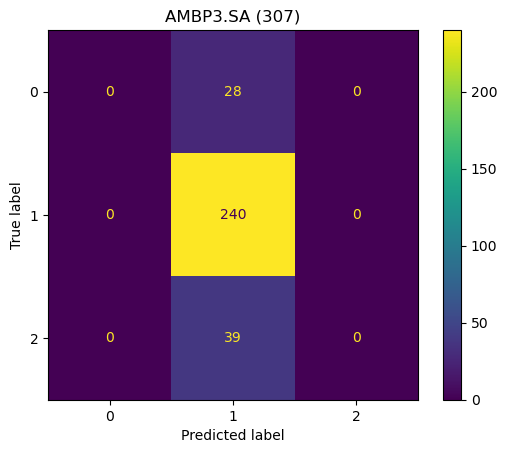

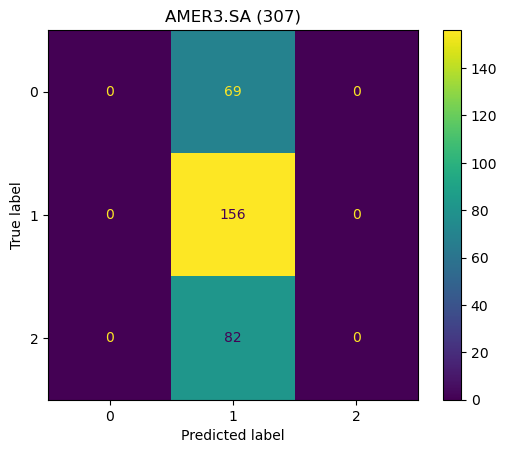

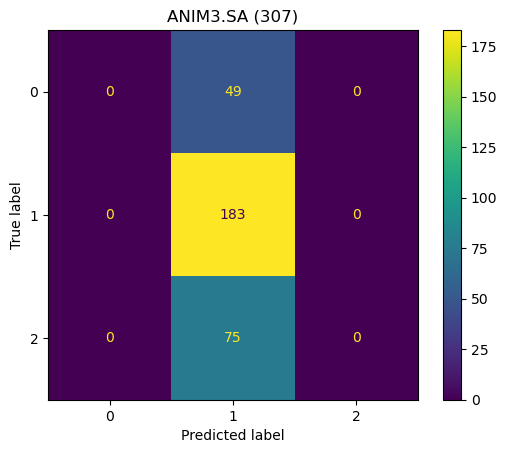

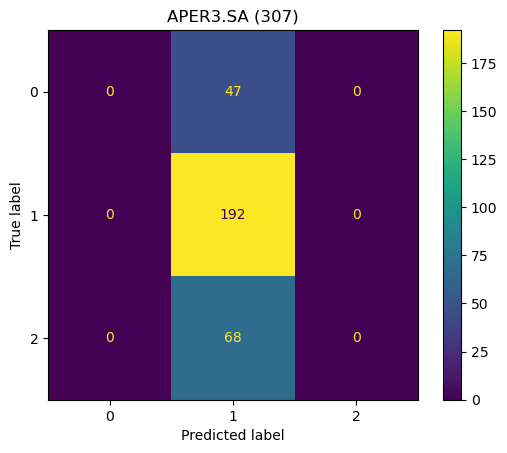

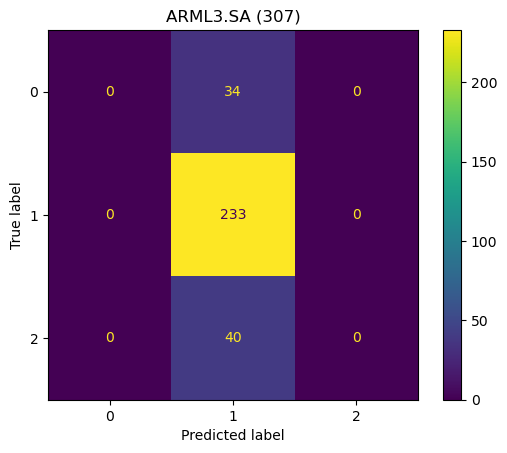

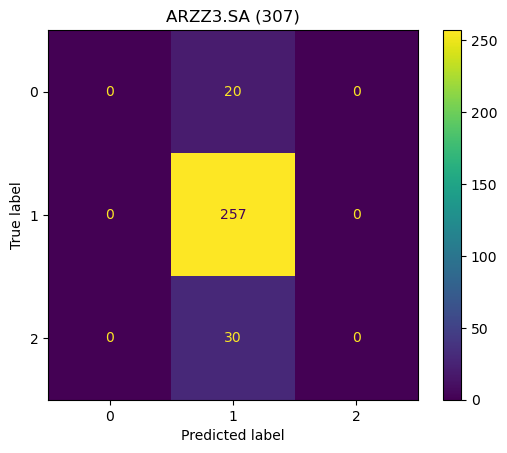

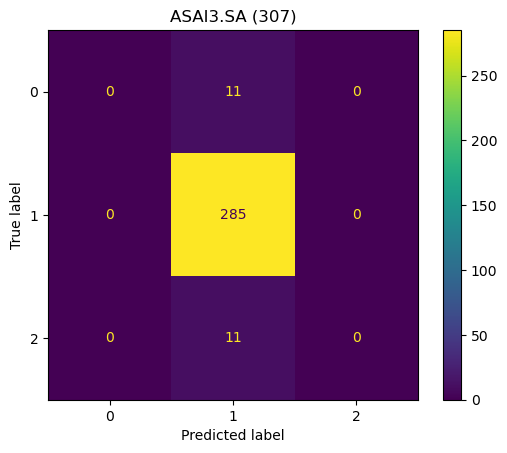

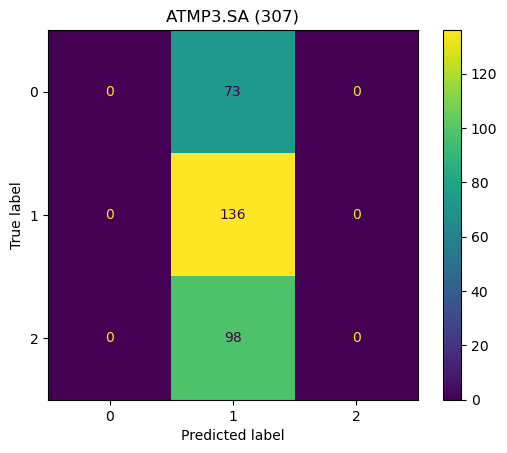

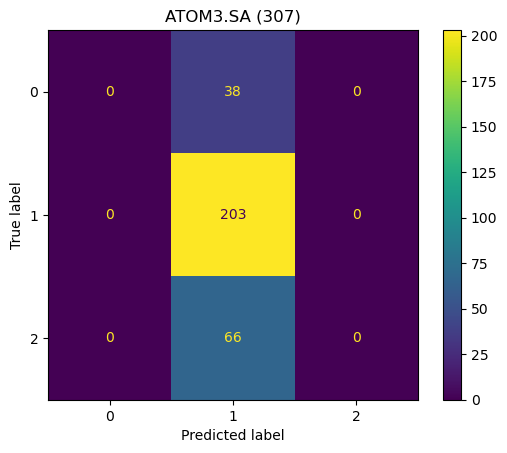

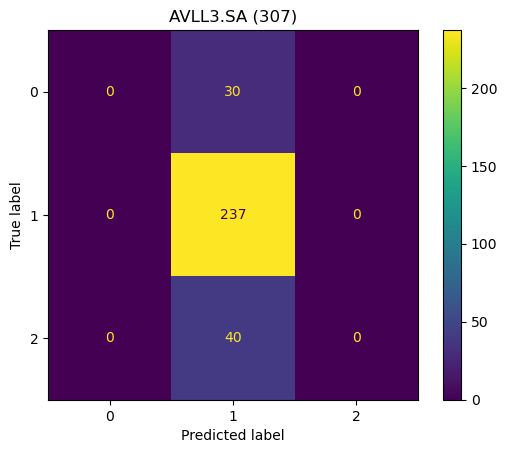

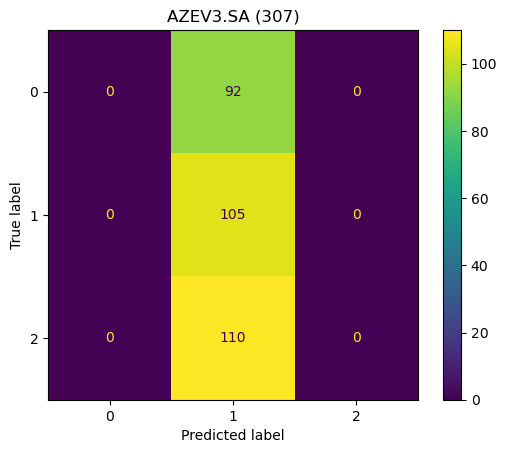

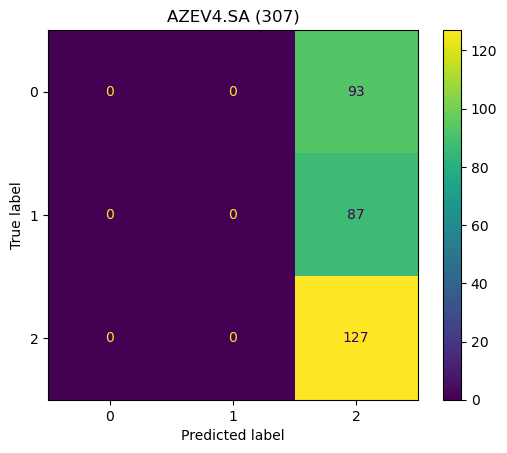

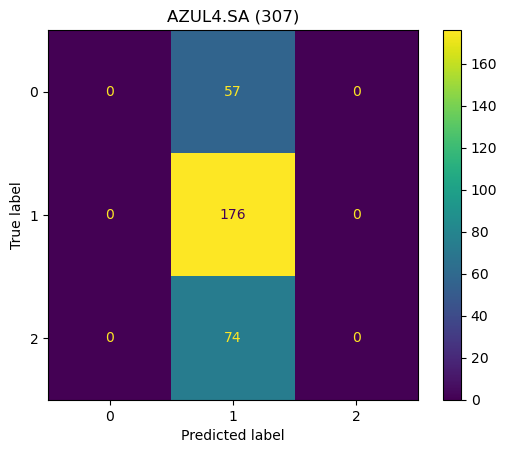

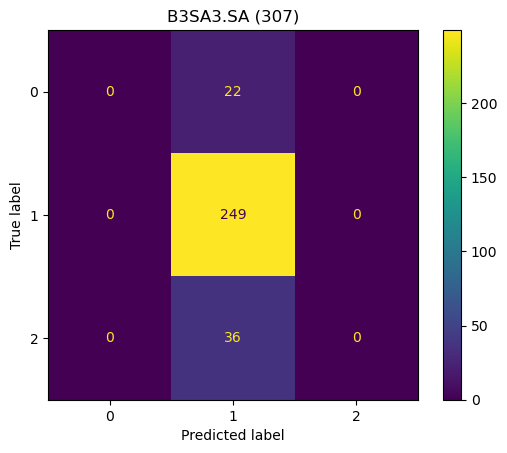

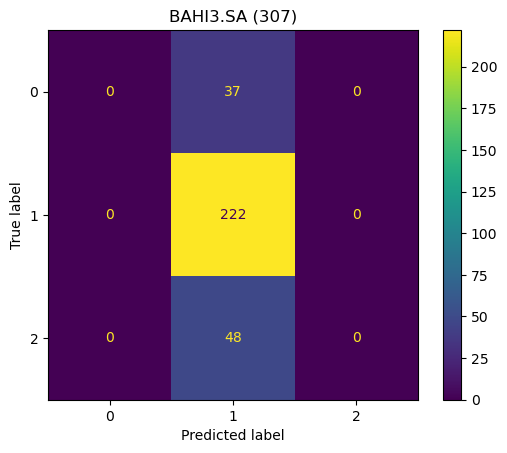

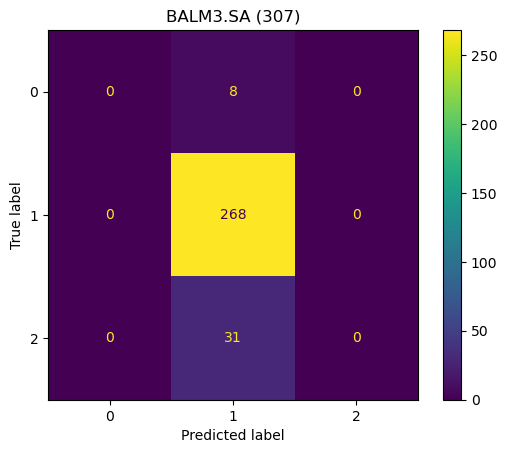

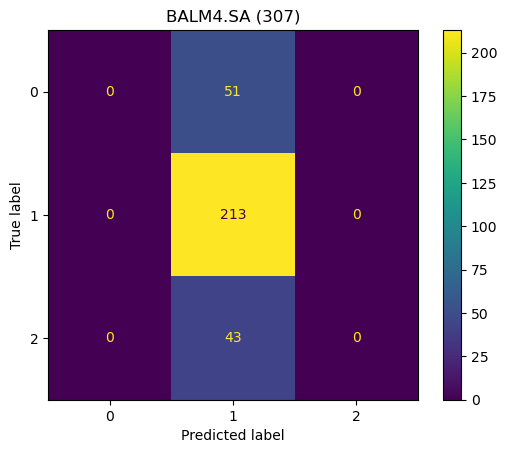

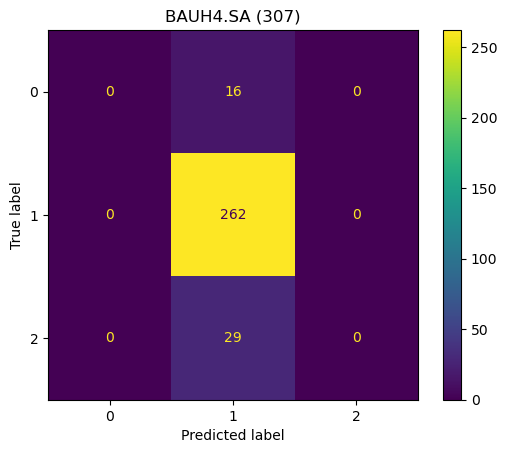

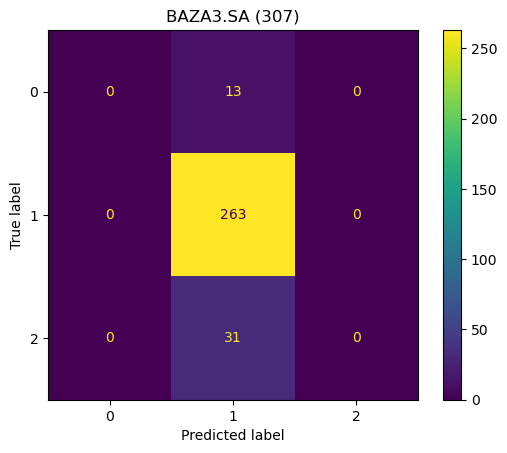

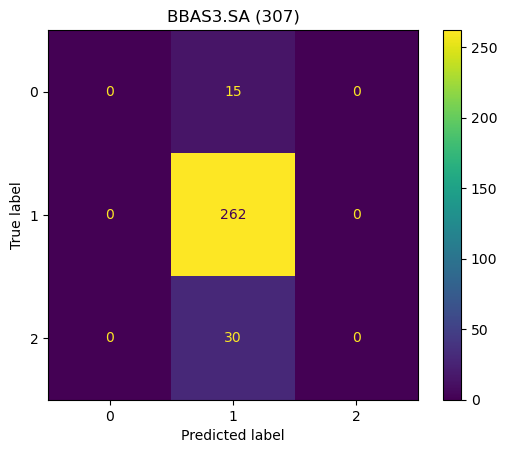

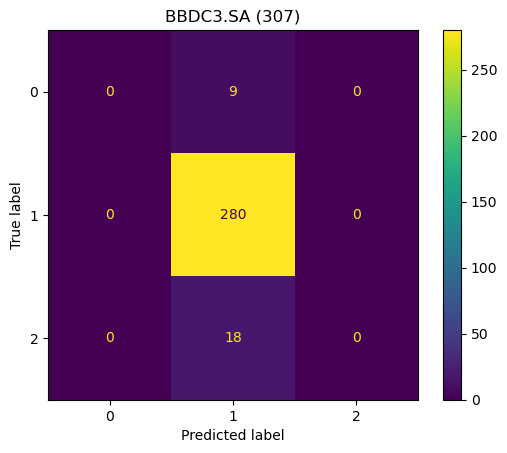

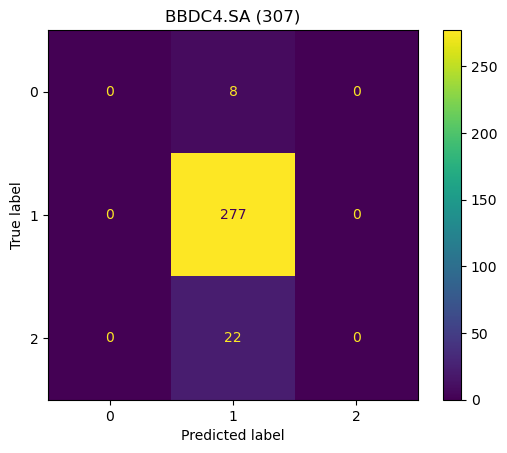

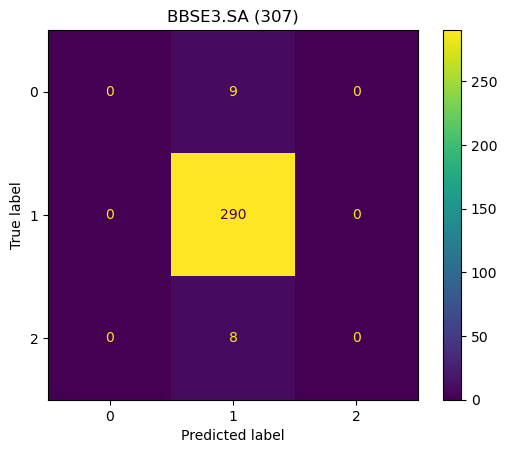

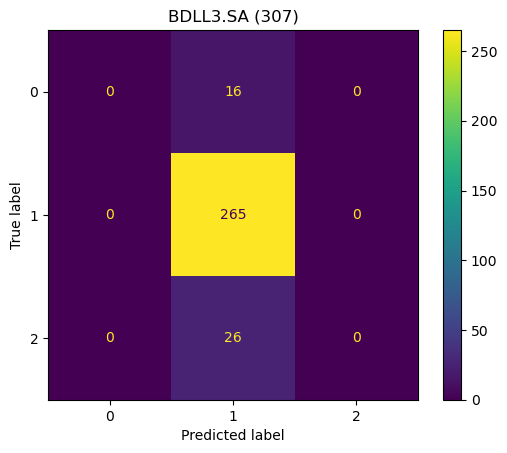

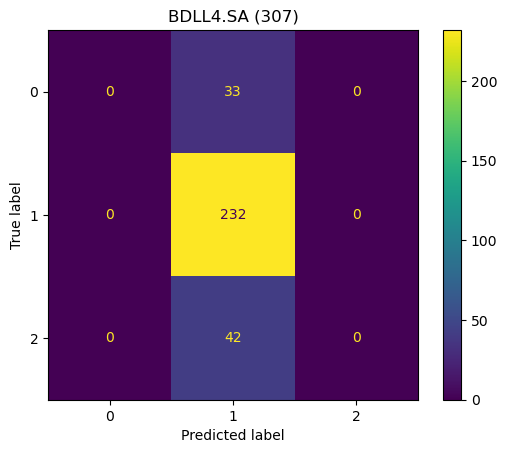

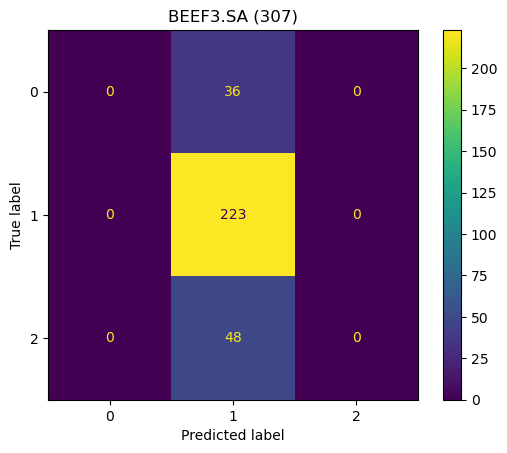

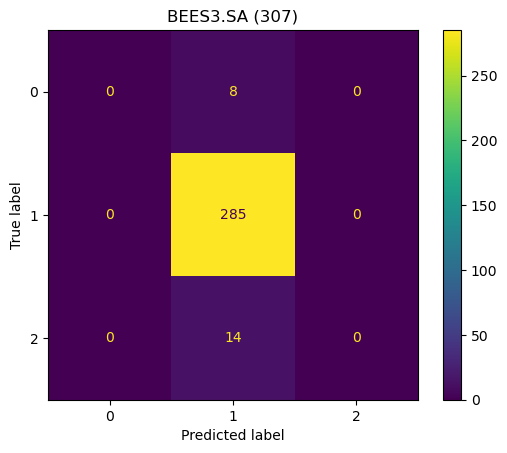

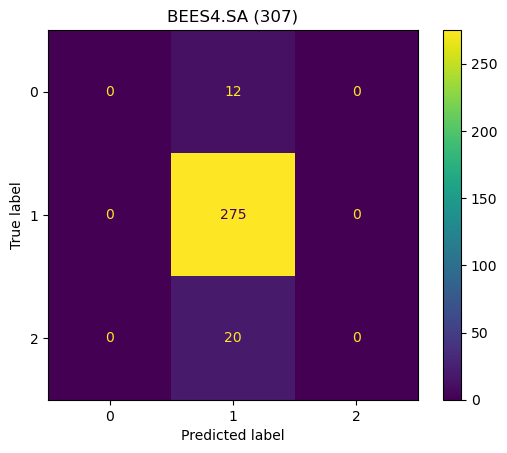

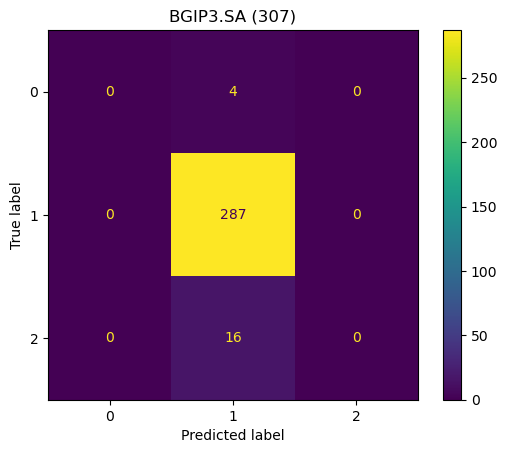

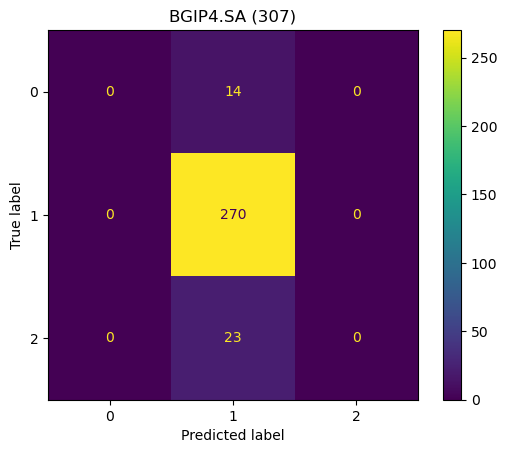

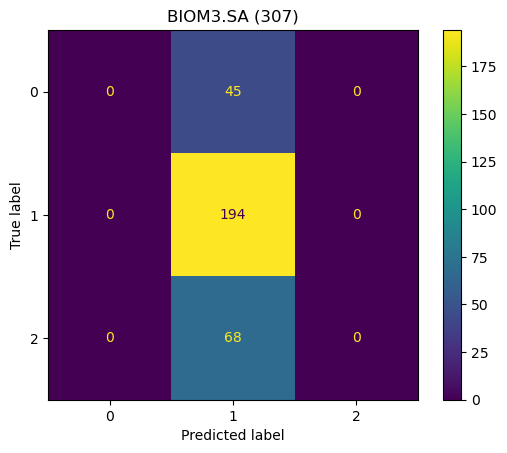

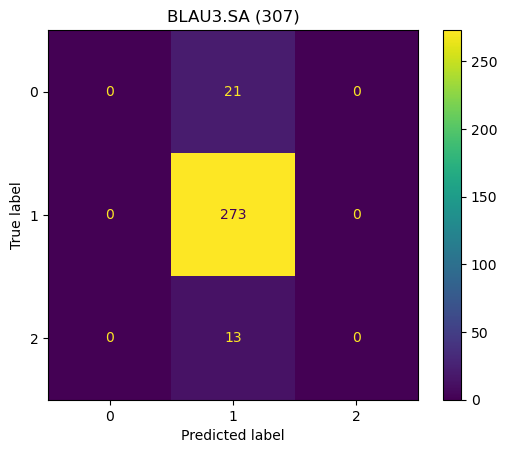

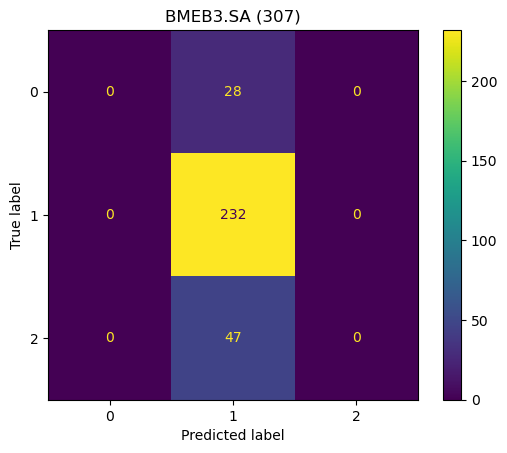

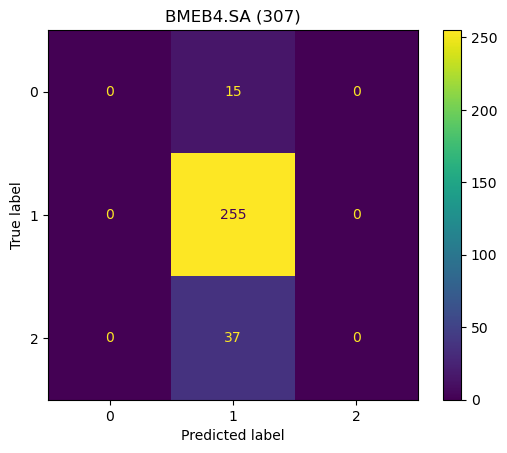

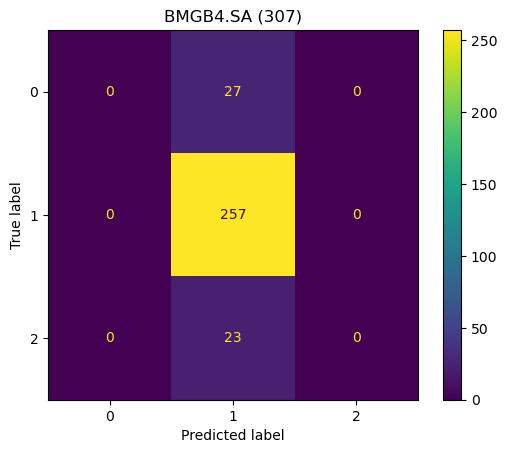

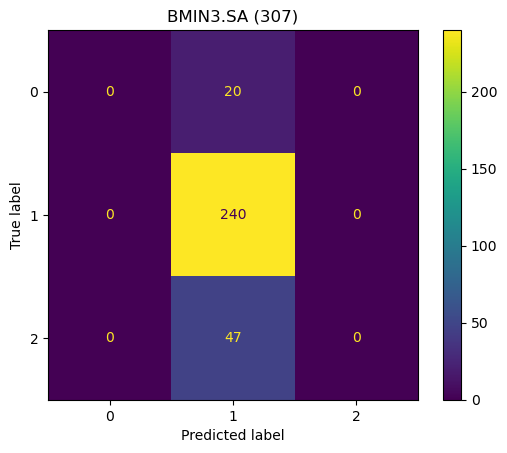

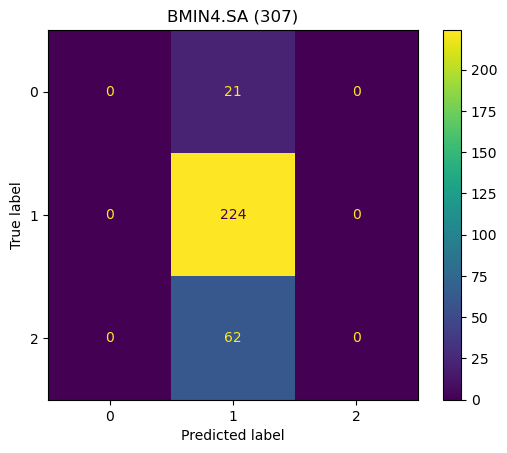

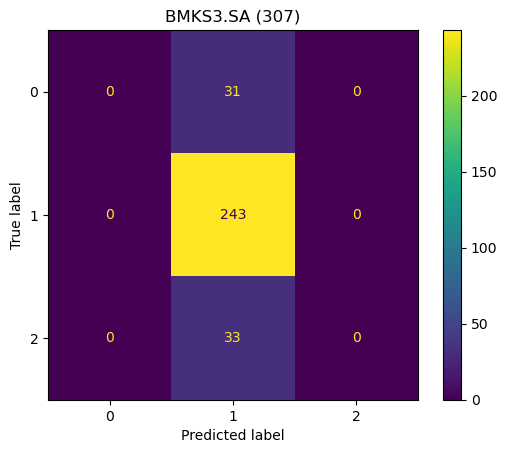

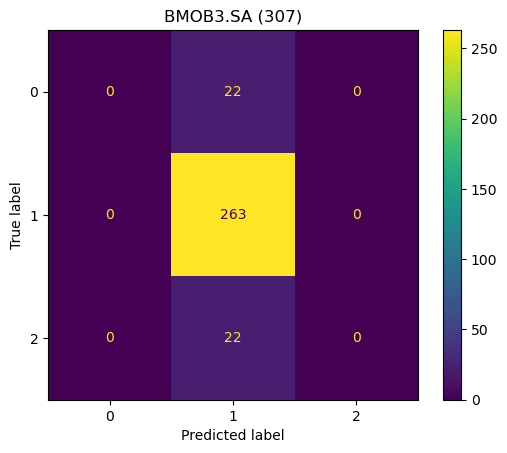

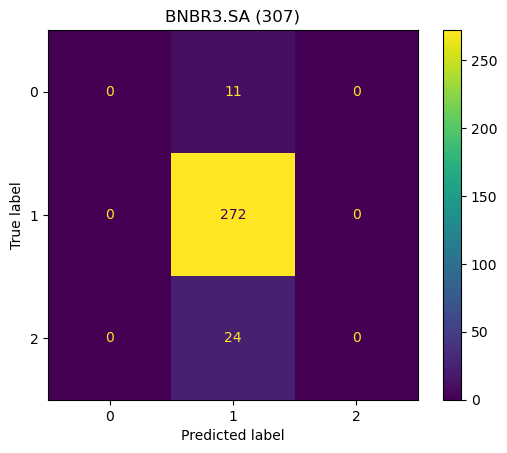

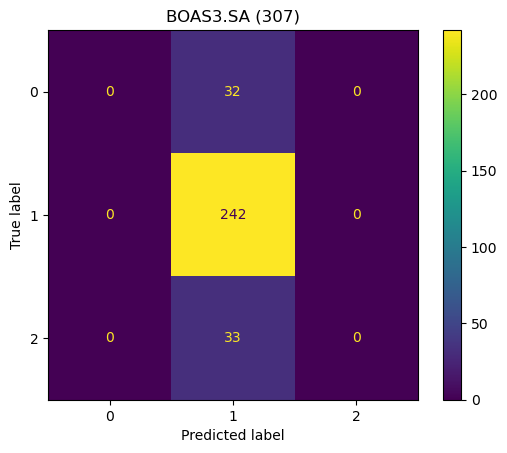

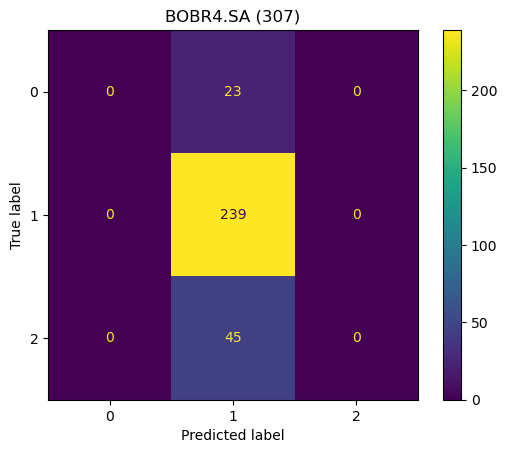

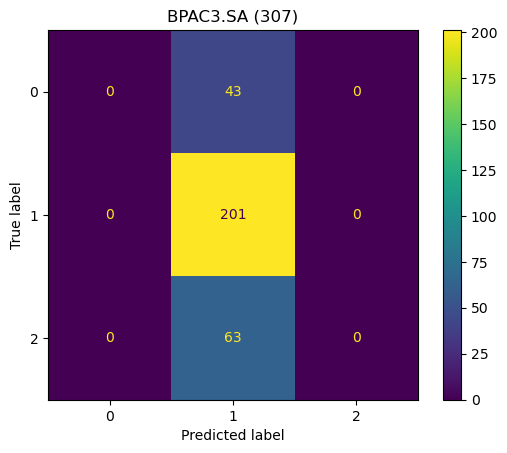

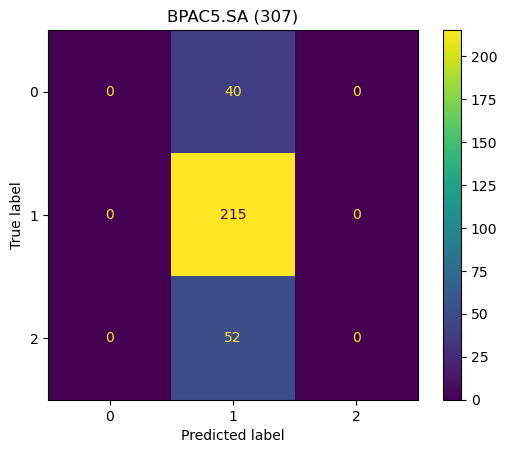

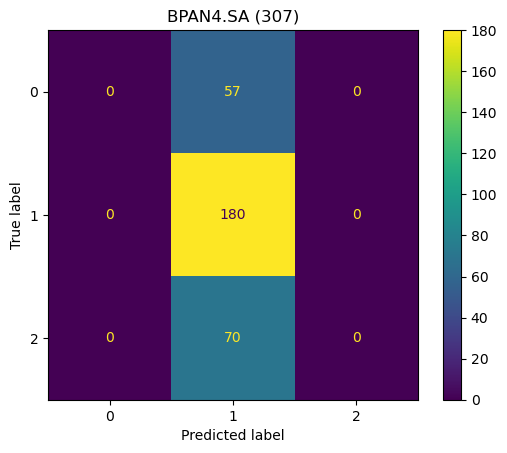

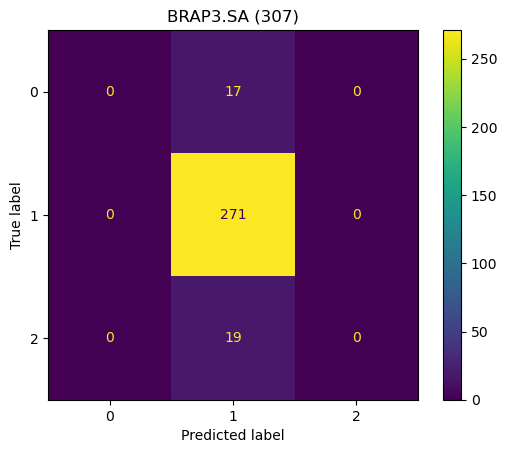

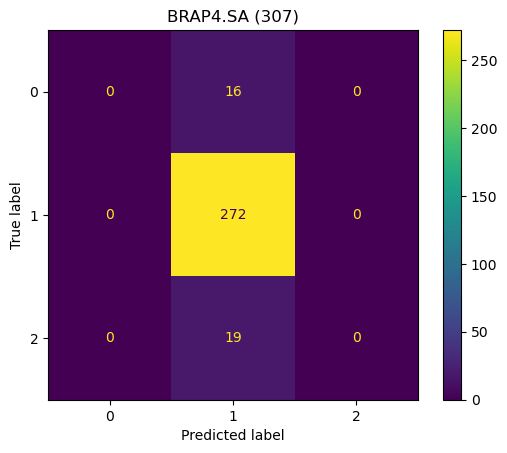

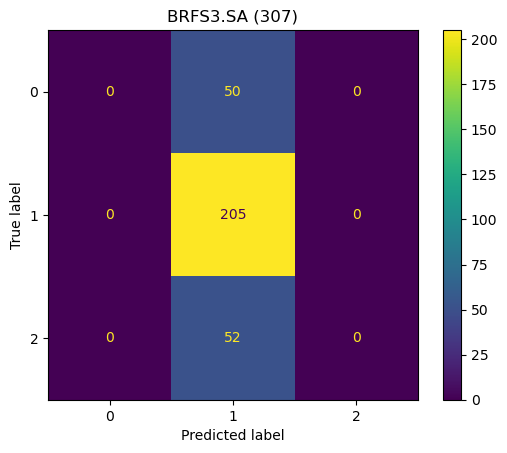

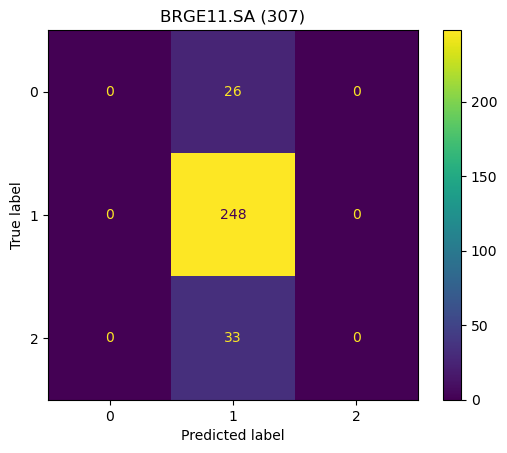

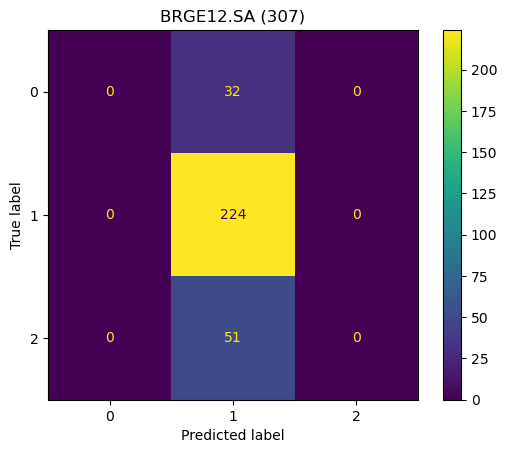

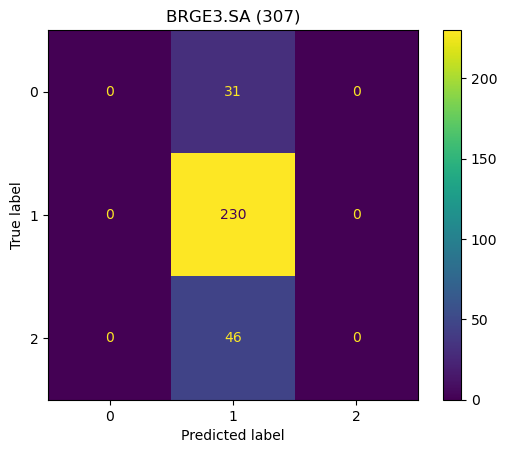

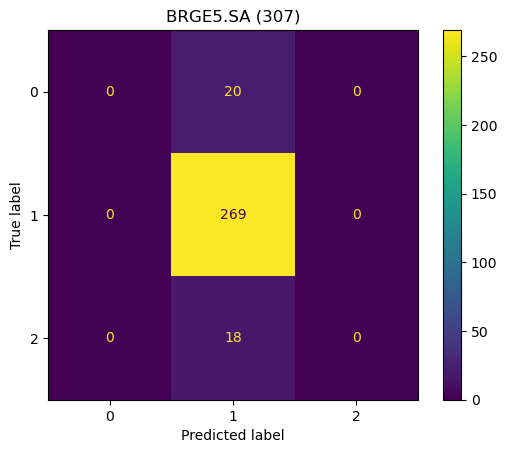

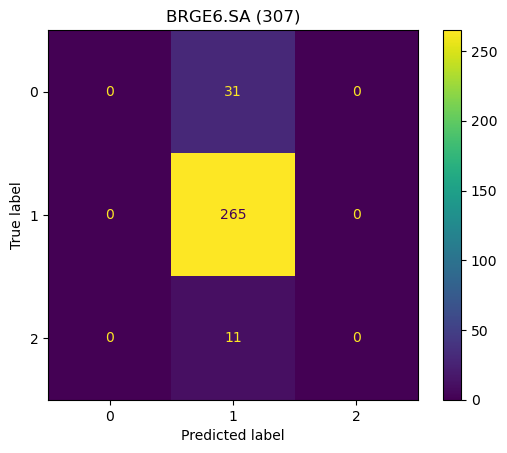

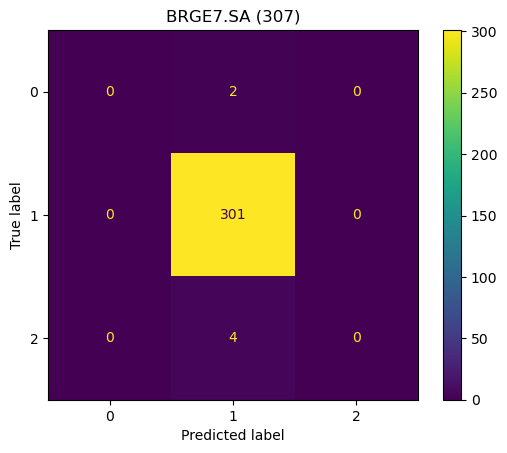

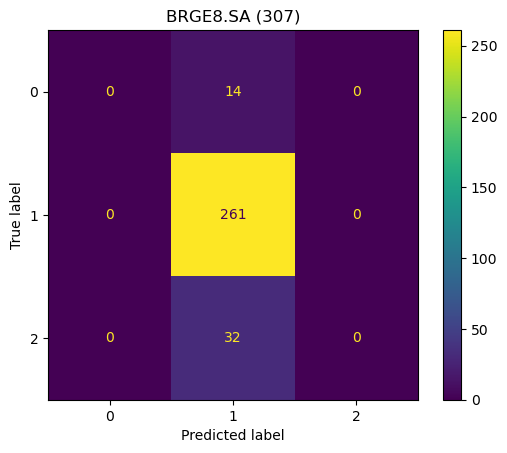

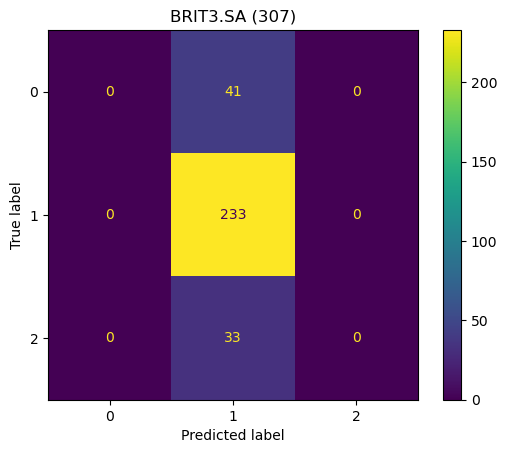

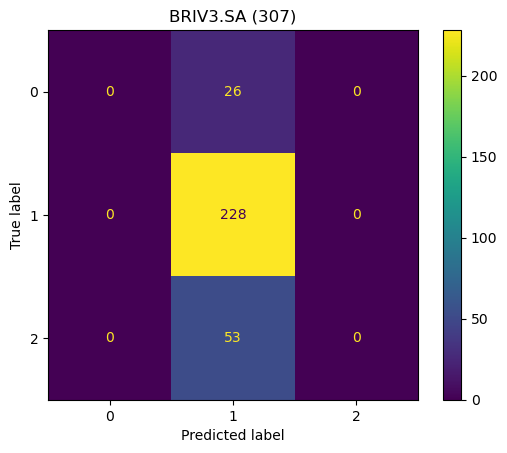

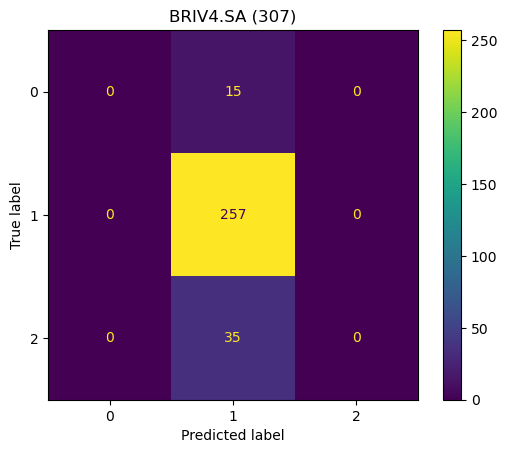

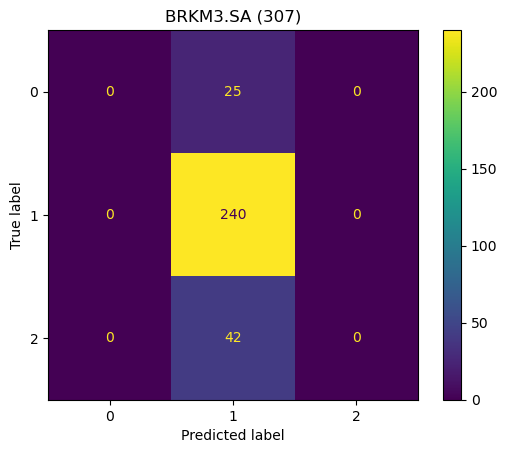

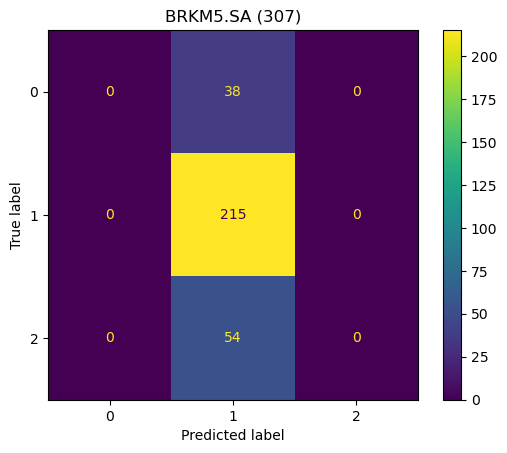

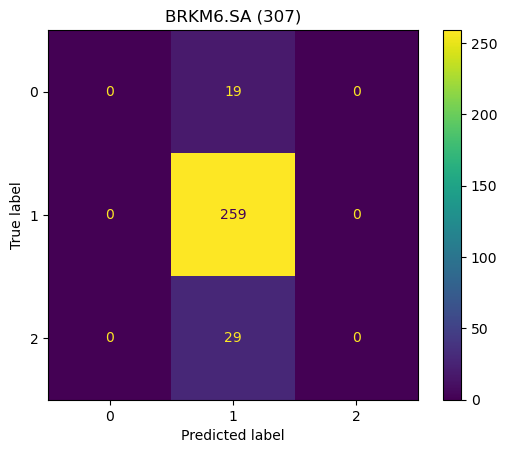

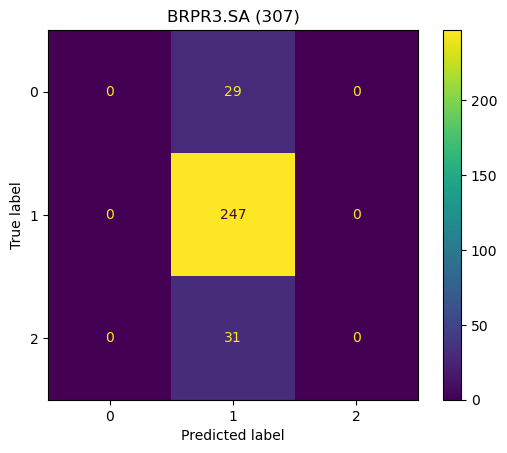

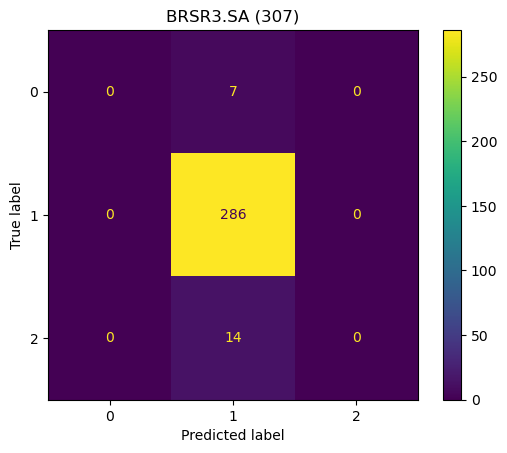

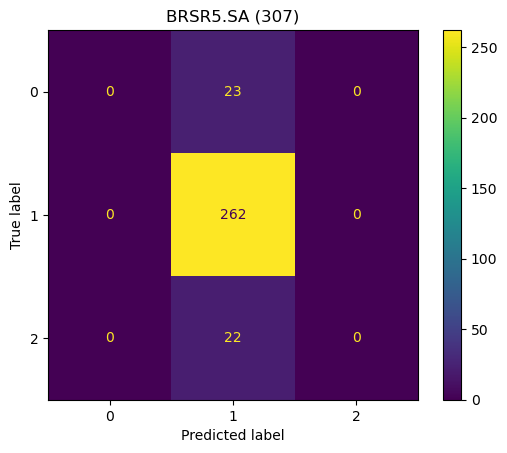

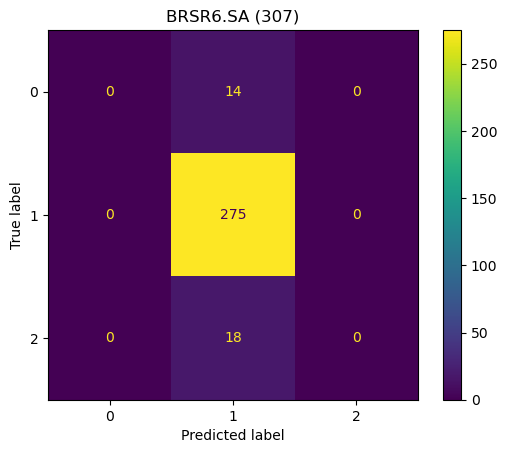

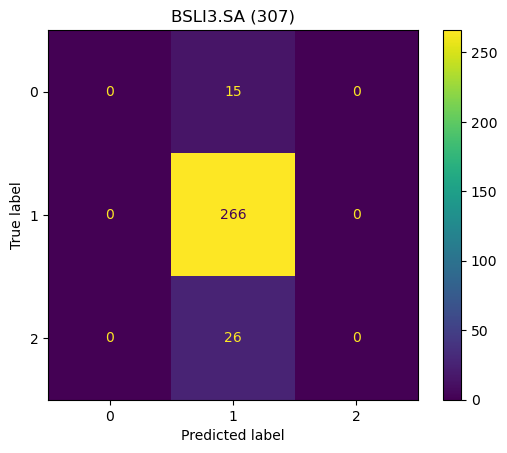

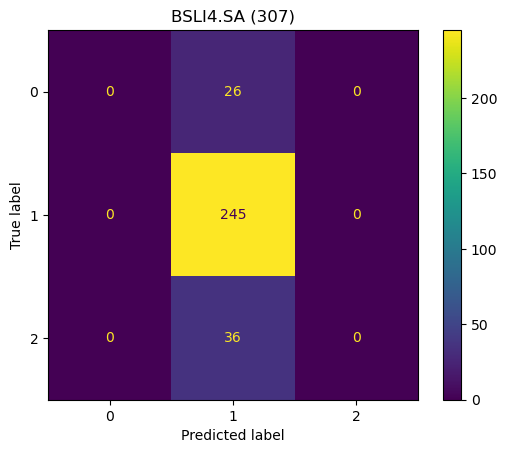

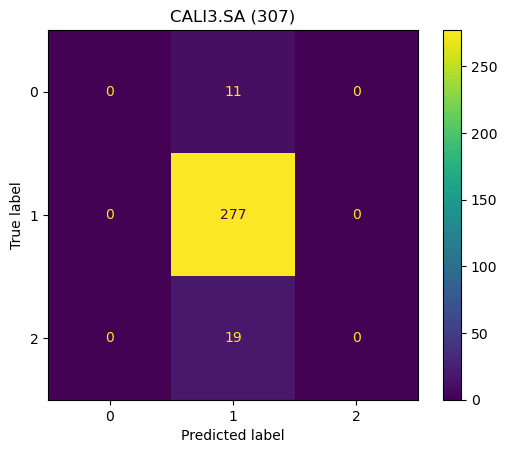

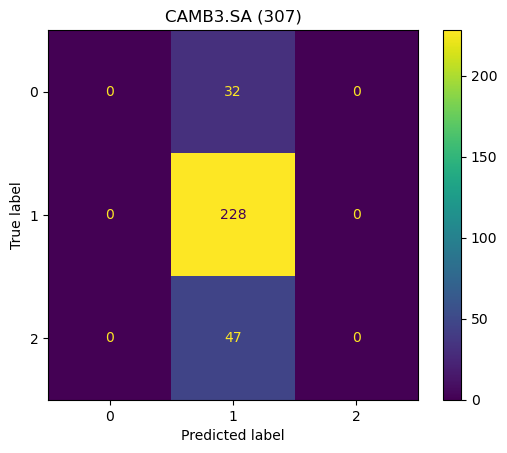

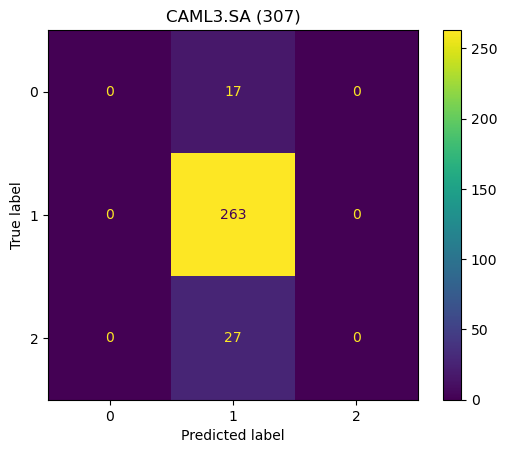

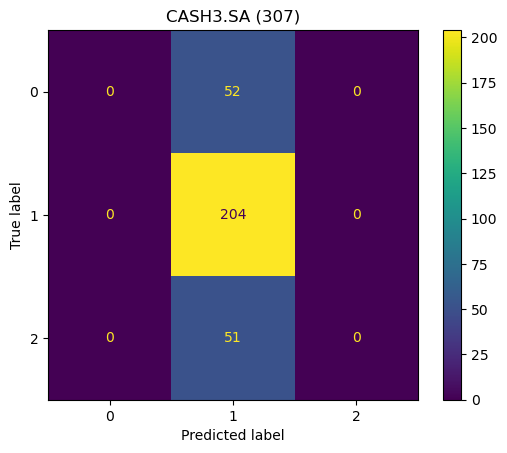

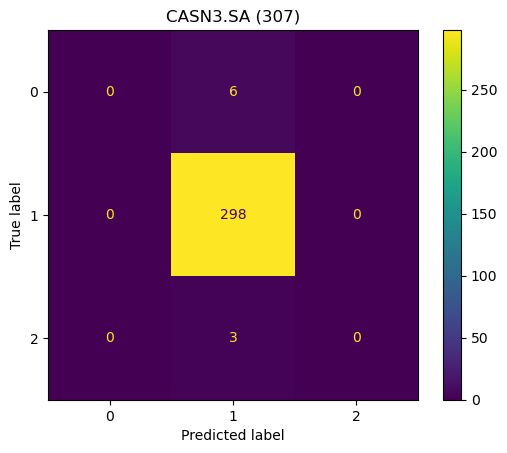

In [183]:
if not os.path.exists('conv_confusion_matrix'):
    os.makedirs('conv_confusion_matrix')

shape_saída = (Prospecção*2)+1 if Categórico and Bidirecional else \
              Prospecção+1 if Categórico else \
              3 if Bidirecional else \
              2


Modelos = {}

for tckr in tqdm(Rótulos.keys()):
    # Cria o objeto de sequência de camadas
    
    Modelos[tckr] = models.Sequential()

    Modelos[tckr].add(layers.Conv2D(64, (2, 2), activation = 'relu', input_shape = Shape))
    Modelos[tckr].add(layers.MaxPooling2D((2, 2)))

    Modelos[tckr].add(layers.Conv2D(64, (2, 2), activation = 'relu'))
    Modelos[tckr].add(layers.MaxPooling2D((2, 2)))

    Modelos[tckr].add(layers.Conv2D(64, (1, 1), activation = 'relu'))
    Modelos[tckr].add(layers.MaxPooling2D((2, 2)))

    Modelos[tckr].add(layers.Flatten())

    Modelos[tckr].add(layers.Dense(64, activation = 'relu'))

    Modelos[tckr].add(layers.Dense(32, activation = 'relu'))

    Modelos[tckr].add(layers.Dense(shape_saída, activation = 'softmax'))

    Modelos[tckr].compile(optimizer = 'adam', 
                    loss = 'sparse_categorical_crossentropy', 
                    metrics = ['accuracy'])

    # Treinamento e teste

    history = Modelos[tckr].fit(Treino_tensor, 
                            Treino_rótulo[tckr], 
                            epochs = épocas, 
                            validation_data = (Teste_tensor, Teste_rótulo[tckr]),
                            callbacks = [early_stopping, checkpoint], # accuracy_callback
                            verbose = 0)
    
    Modelos[tckr].evaluate(Valid_tensor, Valid_rótulo[tckr], verbose = 0)
    
    test_predictions = Modelos[tckr].predict(Valid_tensor)

    test_predicted_labels = np.argmax(test_predictions, axis=1)

    test_true_labels = np.array(Valid_rótulo[tckr])

    cm = confusion_matrix(test_true_labels, test_predicted_labels)

    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

    cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')

    plt.title(tckr+' ('+str(len(test_true_labels))+')')

    plt.savefig('conv_confusion_matrix\\' + tckr+'.png')

* Objeto de tracking para averiguar se os dados não foram desalinhados
* Salvar a acertividade dos modelos por ticker
* Verificar porque alguns gráficos de calor têm menos observações.